In [1]:
"""
2D Quadrotor though a window. - Final Project

This project can be run as a whole by  clicking restart and run all or can be run one cell at a time 
"""
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import math
import matplotlib.patches as patches
# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

from scipy.interpolate import interp1d

In [2]:
class Quadrotor:
    """
    This class describes a quadrotor model
    """
    
    def __init__(self):
        """
        Class constructor, contains information about quadrotor mass intertia and length
        
        """

        self.mass = 0.45 #mass
        self.r = 0.178   #distance from center of quad to each motor
        self.Ixx = 0.001 #Inertia
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01

            
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the cart pole system as a numpy array (y,z,theta,v,k,omega)
        u: control as a 2 demsional force (u1,u2)
        
        Output:
        the new state of the quad as a numpy array
        """
        y = x[0]
        z = x[1]
        theta = x[2]
        v = x[3]
        k = x[4]
        omega = x[5]
        y_next = (y + self.dt * v)
        z_next = (z+self.dt*k)
        theta_next = (theta + self.dt*omega)
        v_next = v + self.dt*( -1*(u[0] + u[1]) * np.sin(theta)/self.mass)
        k_next = k + self.dt*( ((u[0] + u[1]) * np.cos(theta)-self.mass*self.g)/self.mass)
        omega_next = omega + self.dt*((self.r/self.Ixx)*(u[0]-u[1]))
        z = np.array([y_next,z_next,theta_next,v_next,k_next,omega_next])
        return z
    
    def simulate(self, x0, controller, horizon_length):
        """
        This function simulates the quadcopter of horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial state of quad
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        x[1,6xtime_horizon+1] and u[2,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([6, horizon_length+1])
        x[:,0] = x0
        u=np.empty([2,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(x[:,i],i)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
        return x, u        

In [3]:
def animate_quad(x, dt,obstacle = False,window = False,obstacle2 = False,obstacle3 = False):
    """
    This function makes an animation showing the behavior of the quadcopter
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    plot_ob  = []
    fig = mp.figure.Figure(figsize=[8,8])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-7,7], ylim=[-7,10])
    ax.grid()
    
    list_of_lines = []
    
    #create the quadrotor
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    # adding optional obstacle plots (preset values)
    if (obstacle == True):
        circle1 = plt.Circle((0, 0), 0.5, color='r')       
        ax.add_artist(circle1)
        

    if (obstacle2 == True):
        circle2 = plt.Circle((0, 3), 0.5, color='r')
        circle3 = plt.Circle((0, 4), 0.5, color='r')
        circle4 = plt.Circle((0, -1), 0.5, color='r')
        circle5 = plt.Circle((0, -2), 0.5, color='r')
        circle6 = plt.Circle((0, 5), 0.5, color='r')
        ax.add_artist(circle2)
        ax.add_artist(circle3)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)
        
    if (obstacle3 == True):
        circle11 = plt.Circle((0, 3), 0.5, color='r')
        circle7 = plt.Circle((0, 4), 0.5, color='r')
        circle8 = plt.Circle((0, -1), 0.5, color='r')
        circle9 = plt.Circle((0, -2), 0.5, color='r')
        circle10 = plt.Circle((0, 5), 0.5, color='r')
        circle12 = plt.Circle((0, 1), 0.5, color='r')
        circle13 = plt.Circle((0, 2), 0.5, color='r')
        circle14 = plt.Circle((0, 0), 0.5, color='r')
        
        ax.add_artist(circle7)
        ax.add_artist(circle8)
        ax.add_artist(circle9)
        ax.add_artist(circle10)
        ax.add_artist(circle11)
        ax.add_artist(circle12)
        ax.add_artist(circle13)
        ax.add_artist(circle14)

    #optional window plot (preset window location)    
    if (window == True):
        ax.plot([0,0],[1,3],'b',lw=3)
        
        
    quad_r =  0.178
    
    def animate(i):
        #Animates the quad motion
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        y_back = plotx[0,i] - quad_r*np.cos(plotx[2,i])
        y_front = plotx[0,i] + quad_r*np.cos(plotx[2,i])
        z_down = plotx[1,i] - quad_r*np.sin(plotx[2,i])
        z_up = plotx[1,i] + quad_r*np.sin(plotx[2,i])
        
        
        list_of_lines[0].set_data([y_back, y_front], [z_down, z_up])

        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

<IPython.core.display.Javascript object>


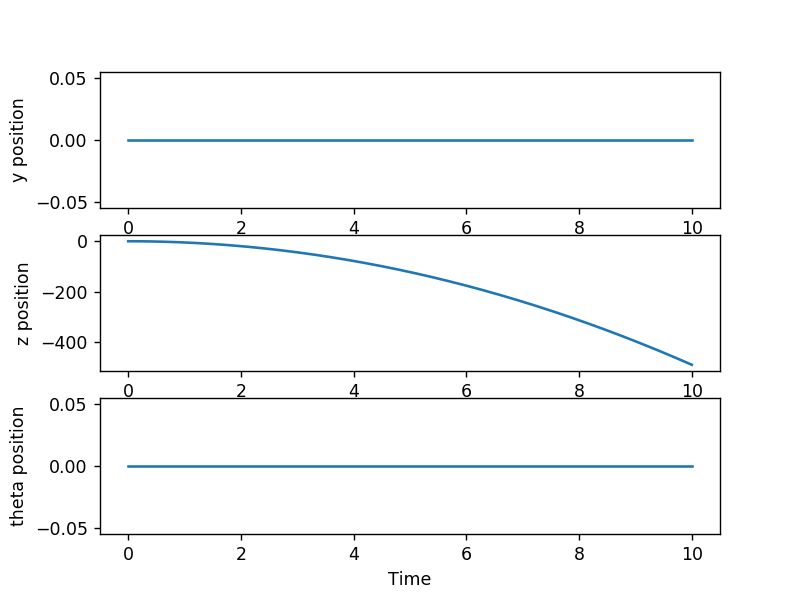

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAm6G1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABG+ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMAIsKw7F+FHM5qOgAAAwAHoAFu
AYEC/Yr8IKGuID1b2meMm54X6fMUy4G4ez04Qv3QvxBbnSynYUdc20rB+wrDSzLZ9e3jebi35LPD
8uRbOoTMHy00ql6j+Zle49E/Tm41pEon0UcBnA4n0M5mzvIaC66/gA+XtmB5eEXYVvqiziFEvdyG
/BRP04/Z6aKyUFm272BkxXLyd8WfLuIjiw3dnmveJvRNeC7kU3eGpP0KGTx8DUes1OGW9PHX/Ga6
IeaFNfX4kmRtXXrLrzHVaES3X6eSSF1tbp70nS7eNfuEPKRDNnmVE5ODEy1g8OUjxDI5DX8REPql
g/8Z0d4yqk9L3zC8YrG1ILX/2Mtg53tV9S04t6ghKeVGxTUEdy697Pae/koN5Yi6fy6HWZwK1FwT
BBpLqDU87FpWB/vJ0NU14y01W9G5k8z5pu/xq/8DnKEfRS4K6blEVr7T3puCxGNyERSVn90Nnq2H
K1pLSvnw+y0bGO5si+zg9aylvzm2EVNf55FIqZn5TwXthkgs2lqzI+KiHkTDLJd2/b+5y/lFF6Pf
LiNcsKjk2Yw7/Xv3ANKvG2WrAtKUrW8pKzRjurTU8rj1CnXCVA0KVM+Jcrfwms6VaD3Vs1iT4aOT
wVu/nu+tmrEjvnrhSKT4BOw5DSw/kBv1+mngymMpYynZ0MInGDnbpT+5uChVUskYvOIDeeZvY7Sy
+STf2mN8j7rCY4d6fQIvbMRogEaw/RR0t5Won0NNhnQ+uOKfy560i/kADcRLvFJbOerKR5O0cfMp
K7i1U7LIhrjo3Mg7f9vLv1J+RUA3+ahb1SpVoGyBzl/a9GGtNZBFmQUPt0ylIN4Tt7JCtMQ+5mw3
9ER/1Daj7ZsIgx3/7OipQQ9VsWnyBNwtsOe4xZkB7WthrFYphSMHpyS2QzNVL6N9O6t+4wsFqX/u
aoIzka3kyIuv+ffAO+1/mrZEwbPWbAChxPnvm7FDkB26zxU1E/x325/3HwetpGph7FxxHRLF9yLb
mLCMpJeW7liVyM1fcsdsuwbL1BPp5M4oEpiAACyWqHBMbEAAAXZK7kABmAYFJf+ZHJfW92srSKrg
UWy0jmbliKd4uzOqgjedDpLobxdn6TZJoZiACmHE1wzj4BXzwhdHwW/x0JdL1IB5E8AZ53LtTWcn
DlUa0ND6/IG+ysrht6NYsM+u0CGLJJrfvzcFlJ5BcpvCEUWcaLfnYS/hza7CkoNEo1ulWq3qupXg
p3b8U9q9NRTvGMQcoK7tBToNNncrFCLM+7tAg+XJJX5ABvVuEZdOJ2d8mbUVjoU8iWDr7cpH6QYz
ZxrR5oda9m+V2NqEPAiFg+rOzdsVT7lTJfpgEu9ppdQLeWqY7c4Ws+jxhmazrf//uKNDoATrYpZK
UErBFv9hRV6lwVeex05+fV1VFqGPsOjgypD81fbJ9kemORAdq5X7dA9Biii6ebtJxIG8CF3SMNGm
2e2tOri8azYweJXTZOygB596ZpPsOtGZ3wYe/RtvmTEntKkMJU8ibyfQ8tibTQXwFrymFMHntt45
rhUrdWrFweRL8Gq1zeLpdJBGjPq06WQKCsnEqLHSh7EronpYtutOlRk0xMhbYoirzigqEP0ALqsS
36dk5QnByRv7QJ+EMz/G/xY2VXakyIj9vTwSPCZLRdU8N7pVcFea9VZwGKCZ3v2ruUXnNihLrqs3
BHJ5M8nFUKr6ufzb3uLnInLp9yPDW5TDCXMvD9QYPWldI4S/cEVVJBN+zXfiejvvQVtibLo4pgzZ
GXGb8kSMmWpm07d4pgiMlLoVCWdLAfU//o6eb3pzzFozKCnpbv/VkvuFPuIMwExA2FJzYp+68hEP
ns/2/4XcO1yBthb4LPPOrVzXHssbsPVTDDZwo71rTq1+hfw0vSv9EaYsAAAesZ/Z5woggq0MFRrc
quXC2AUXqkiOuijXage6yjcDOYKeO7WXjBaGWtBYNQQgd8J057wb3ckLWkk4raVY9iUm4H1+39xf
O7xDJEZTo+Hqwq4if7SEmJyLp8qfQmXAUQPg2jgtH8iEe71n5WRvVhkUJRKzJN7f70wVcYLwjuQd
yW/FT4y4K+0XYtAjYYhPbWNh/CpVfGkO0J6I2VjAaB8TbF3aLKT/IiKE87RA4mYO4QLKDmmDaoIE
xCL1v1B7dfWyEMaxP3+6tttjXWjZGjADY+LCB1mRrXDfCkKe3iw94UzswOthNPi2yLr9jKhhFEQ6
sBqzHM1nx9c4fPb24o6lQjEM4PssYHfSYDv21QfVprpO4ZmYPm6Df5Afc6TFXiF0JTDr3nlg4glZ
xoM/Ifb468tajP1E4zGGt1saPvufBYQaNy6kPoSZ7/kr9dyXsSqRbBQ7E8rpkxwk0AA2nFEh+QQW
u4JC+mrvoGtICIZLreUQ1X7iUSVGsUm4f6EFCwz36j3cfVJ++xtnenGgc/ErnVMXxe9a/DOsL5OV
LCq2eC2vuP+3BWcjvpRQlVxDnrZ4llepCjbZwrWgdyOB/fWss03QcT0F9KeE3qpQLwUvwH8pE11A
5XKWCOrtg3hXQDdnudy/K4MJeQPRduM6p5TyphfBFKJysfQft/LDWvaq3unYLhg1TcbnfPCmC1fq
MJ2BglzxSTmayCNtbRF/ZKO+S1AqB8BMF6JHOUA7UpSxaH5788vAyOoW7yxERcWP9Bd6nWA2kvSl
ndr90/T9LbKkjbWGIPT0jXMQiTDUcn9TYwJj57/8BKfvUFrHpZ8F0JPtMVn9066/b1iQ6K7czINb
qwz5gCJIgYU8ewO6WjwNHU8zXFnCPREemM2gsEAnbeO3rzsCp8cD4xHasBAvMQhH4XBiWeBbONdu
w2R4oi30g8QAAJVplwEDf

In [4]:
# An example to test the quadcopter behavior with no control

# create a quadcopter
quad = Quadrotor()

# a controller that does nothing 
def useless_controller(x,i):
    return [0,0]

#simulate the quadcopter and display its behavior 
x0 = np.array([0,0,0,0,0,0])
horizon_length = 1000

x,u = quad.simulate(x0, useless_controller, horizon_length)
t = np.linspace(0,quad.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,x[0,:])
plt.ylabel('y position')
plt.subplot(3,1,2)
plt.plot(t,x[1,:])
plt.ylabel('z position')
plt.subplot(3,1,3)
plt.plot(t,x[2,:])
plt.ylabel('theta position')
plt.xlabel('Time')


animate_quad(x, quad.dt)

In [5]:
def trajectory(t,y,z,kind_y,kind_z):
    #to generate trajectory of a specific kind - kind can be cubic, zero, quadreadtic, linear etc.
    f_y = interp1d(t, y, kind=kind_y)
    f_z = interp1d(t, z,kind=kind_z)
    return f_y,f_z

In [6]:
def trajectory_autoGenerate(t,y,z):
    #Automatically interpolates data and generates a trajectory
    f_y = interp1d(t, y)
    f_z = interp1d(t, z)
    return f_y,f_z

In [7]:
def jacobian(quad,x,u):
    #Calculate the jacobian of the system dynamics with respect to x (=A) and u (=B)
    A = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -(1/quad.mass)*(u[0]+u[1])*np.cos(x[2])*quad.dt, 1, 0, 0], [0, 0, -(1/quad.mass)*(u[0]+u[1])*np.sin(x[2])*quad.dt, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
    
    B = np.array([[0, 0],[0, 0], [0, 0],[-(1/quad.mass)*np.sin(x[2])*quad.dt, -(1/quad.mass)*np.sin(x[2])*quad.dt], [(1/quad.mass)*np.cos(x[2])*quad.dt, (1/quad.mass)*np.cos(x[2])*quad.dt], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])
    return A,B

In [8]:
def finite_horizon_controller(x,i):
    '''
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length
    '''
    u = u_guess[:,i]+K_FH[i].dot(x-x_guess[:,i]) + k_FH[i] 
    
    return u

In [9]:
def solve_ricatti_equations(x_guess,u_guess,Q,R,x_desired, horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min sum(xQx + uRu) + xQx subject to xn+1 = Axn + Bun
    
    Arguments:
    x_guess, u_guess - nominal trajectory and control
    Q, R: numpy arrays defining the problem
    x_desired - desired trajectory
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from 0 to N
    K: list of numpy arrays containing Kn from 0 to N-1
    p: list of numpy arrays containing pn from 0 to N
    k: list of numpy arrays containing kn from 0 to N-1
    """
    
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0
    p = [] #will contain the list of ps from N to 0
    k = [] #will contain the list of ks from N-1 to 0
    q = [] #will contain the list of qs from N to 0
    
    
    for i in range(horizon_length+1): 
        qnew = np.array(-1*np.matmul(Q,x_guess[:,horizon_length-i]))
        q.append(qnew)
        
    P.append(Q)
    p.append(q[0])
    
    for i in range(horizon_length):
        
        A,B = jacobian(quad,x_guess[:,horizon_length-i-2],u_guess[:,horizon_length-i-2])
        
        Knew = -1.0 * np.linalg.inv(B.transpose().dot(P[i]).dot(B) + R).dot(B.transpose()).dot(P[i]).dot(A)
        Pnew = Q + A.transpose().dot(P[i]).dot(A) + A.transpose().dot(P[i]).dot(B).dot(Knew)
        knew = -1.0 * np.linalg.inv(R + B.transpose().dot(P[i]).dot(B)).dot(B.transpose()).dot(p[i])
        pnew = q[i+1] + A.transpose().dot(p[i]) + A.transpose().dot(P[i]).dot(B).dot(knew)
        K.append(Knew)
        P.append(Pnew)
        k.append(knew.T)
        p.append(pnew)
        
    
    # since we went backward we return reverted lists
    return P[::-1],K[::-1],p[::-1],k[::-1],q[::-1]


In [10]:
def linearize_final(x_star,x_goal,Q):
    #linearize the final cost - For solving obstacle problem
    lx = (x_star - x_goal).transpose().dot(Q);
    #print(np.shape(lx))
    lu = np.array([0, 0])
    lxx = Q
    luu = np.array([[0, 0], [0, 0]])
    lux =np.array([[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
    return lx,lu,lxx,luu,lux

In [11]:
def distance(x,x_obs):
    #calculate the distance from centre of obstacle to the current point
    #- For solving obstacle problem
    d=[]
    for i in range(len(x_obs)):
        x = np.array([x[1],x[2],0,0,0,0]).transpose()
        diff = x-x_obs[i]
        dist = np.sqrt(diff.transpose().dot(diff))
        d.append(dist)
    return d 

In [12]:
def CalculateQ(lx, lu, lxx, luu,lux,A,B,s,S,rho):
    #Calculate Q terms 
    #- For solving obstacle problem
    Qx = lx + s.dot(A)
    Qu = lu + s.dot(B)
    Qxx = lxx + A.transpose().dot(S).dot(A)
    Quu = luu + B.transpose().dot(S).dot(B)
    Qux = lux + B.transpose().dot(S).dot(A)

    Quu_bar = luu + B.transpose().dot(S+rho*np.eye(6)).dot(B)
    Qux_bar = lux + B.transpose().dot(S+rho*np.eye(6)).dot(A)
    return Qx.T,Qu.T,Qxx,Quu,Qux,Quu_bar,Qux_bar

In [13]:
def Calculate_obs_lx_term(x,x_obs,d):
    #compute one of the lx term's value
    #- For solving obstacle problem
    sum_of_terms = np.zeros([np.size(x),1])
    x_ = np.array([x[1],x[2],0,0,0,0])
    
    for i in range(len(d)):
        diff = (x_-x_obs[i]).reshape(len(x),1)
        sum_of_terms = sum_of_terms + diff*np.exp(-d[i])/d[i]
    return sum_of_terms.transpose()

In [14]:
def Calculate_lxx_term(gamma,x_g,x_obs,d,x_d):
    #compute one of the lxx term's value
    #- For solving obstacle problem
    lx_term = np.zeros([len(x),len(x)])
    x_ = np.array([x_g[1],x_g[2],0,0,0,0]).transpose()

    for i in range (len(x)):
        for j in range (len(x)):
            temp = 0
            if i == j:
                for k in range(len(d)):
                    temp = temp + gamma * np.exp(-d[k])* (((x_[i] - x_obs[k][i])**2)*(1/(d[k]**3)+1/(d[k]**2)) -1/d[k])
            else:
                for k in range(len(d)):
                    temp = temp + gamma * np.exp(-d[k])* (x_[i] - x_obs[k][i])*(x_[j] - x_obs[k][j])*((d[k]**2)+(d[k]**3))/(d[k]**5)
            lx_term[i,j] = temp
                    
    return lx_term

In [15]:
def linearize_intermmediate(Q,gamma,x_g,x_obs,d,x_d,R,u): 
    #- Linearize intermmediate costs
    #- For solving obstacle problem
    diff_d =(x_g - x_d)
    lx_obs = Calculate_obs_lx_term(x_g,x_obs,d)
    lx = diff_d.transpose().dot(Q) - gamma * lx_obs
    lu = u.transpose().dot(R)
    luu = R
    lxx = Q + Calculate_lxx_term(gamma,x_g,x_obs,d,x_d)
    lux = np.array([[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
    return lx, lu, lxx, luu,lux

In [16]:
def backward_pass(rho,gamma,x_guess,u_guess,Q,R,x_desired, horizon_length,x_obs):
    """
    This function solves the backward pass for ILQR - For solving obstacle problem
    returns S,s,K,k 
    """
    s = [] #will contain the list of ss from N-1 to 0
    S = [] #will contain the list of Ss from N-1 to 0
    K = [] #will contain the list of Ks from N-1 to 0
    k = [] #will contain the list of ks from N-1 to 0
    lf = 1/2*(x_guess[:,horizon_length]-x_desired[:,horizon_length]).transpose().dot(QN).dot((x_guess[:,horizon_length]-x_desired[:,horizon_length]))
    lx, lu, lxx, luu,lux = linearize_final(x_guess[:,horizon_length],x_desired[:,horizon_length],QN)
    sn = (QN).dot(x_guess[:,horizon_length] - x_desired[:,horizon_length]).reshape(1,6)
    Sn = QN
    
    s.append(sn)
    S.append(Sn)
    #l_original = lf
     
    for i in range(horizon_length):
        A,B = jacobian(quad,x_guess[:,horizon_length-i-2],u_guess[:,horizon_length-i-2])
        Qx,Qu,Qxx,Quu,Qux,Quu_bar,Qux_bar = CalculateQ(lx, lu, lxx, luu,lux,A,B,sn, Sn,rho)
        
        d = distance(x_guess[:,horizon_length-i],x_obs)
        
        Kn = - np.linalg.inv(Quu_bar).dot(Qux_bar)
        
        kn = - np.linalg.inv(Quu_bar).dot(Qu)

        
        Sn = Qxx + Kn.transpose().dot(Quu).dot(Kn)+Kn.transpose().dot(Qux)+Qux.transpose().dot(Kn)
        #print(np.shape(Qu),np.shape(Qx),np.shape(Qu),np.shape(kn))
        sn = (Qx + Kn.transpose().dot(Quu).dot(kn)+Kn.transpose().dot(Qu)+Qux.transpose().dot(kn)).reshape(1,6)
        lx, lu, lxx, luu,lux = linearize_intermmediate(Q,gamma,x_guess[:,horizon_length-i],x_obs,d,x_desired[:,horizon_length-i],R,u_guess[:,horizon_length-i-1])
        
        K.append(Kn)
        k.append(kn.T)
        S.append(Sn)
        s.append(s)
    
        
    
    # since we went backward we return reverted lists
    return S[::-1],K[::-1],s[::-1],k[::-1]


In [17]:
def forward_pass(x0,K,k,x_guess,u_guess,x_des):
    #Calculate forward pass 
    #- For solving obstacle problem
    x_n = np.zeros(np.array(x_guess.shape))
    u_n = np.zeros(np.array(u_guess.shape))
    x_n[:,0] = x0
    alpha = 0.5  
    for i in range(len(u_guess.T)):
        delta_x = x_n[:,i] - x_guess[:,i]
        u_n[:,i] = (u_guess[:,i] + K[i] .dot((delta_x))+alpha*k[i]) #+[0.45*9.8/2,0.45*9.8/2]
        x_n[:,i+1] = quad.next_state(x_n[:,i],u_n[:,i])
        
    return x_n,u_n 

In [18]:
def simulate(x_guess,u_guess,K,k):
    # calculates and returns updated nominal trajectory and control
    x_n = np.zeros(np.array(x_guess.shape))
    u_n = np.zeros(np.array(u_guess.shape))
    x_n[:,0] = x_guess[:,0]
    alpha = 1  
    for i in range(len(u_guess.T)):
        u_n[:,i] = (u_guess[:,i] + K[i] .dot((x_n[:,i]-x_guess[:,i])-x_desired[:,i])-alpha*k[i])
        x_n[:,i+1] = quad.next_state(x_n[:,i],u_n[:,i])
        
    return x_n,u_n 

In [19]:
def solve_ricatti_equations_init(A,B,Q,R,z_desired, horizon_length):
    """
    This is used to solve the LQR initially to get the first guess
    This function solves the backward Riccatti equations for regulator problems of the form
    min sum(xQx + uRu) + xQx subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    z_desired : desired trajectory
    horizon_length: length of the horizon
    
    Returns: P,K,p,k,q
    """
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0
    p = [] #will contain the list of ps from N to 0
    k = [] #will contain the list of ks from N-1 to 0
    q = [] #will contain the list of qs from N to 0
    
    
    for i in range(horizon_length+1):
        qnew = -1*np.matmul(Q,z_desired[:,horizon_length-i]).reshape((6, 1))
        q.append(qnew)
        
    P.append(Q)
    p.append(q[0])
    
    for i in range(horizon_length):
        Knew = -1.0 * np.linalg.inv(B.transpose().dot(P[i]).dot(B) + R).dot(B.transpose()).dot(P[i]).dot(A)
        
        Pnew = Q + A.transpose().dot(P[i]).dot(A) + A.transpose().dot(P[i]).dot(B).dot(Knew)
        knew = -1.0 * np.linalg.inv(R + B.transpose().dot(P[i]).dot(B)).dot(B.transpose()).dot(p[i])
        pnew = q[i+1] + A.transpose().dot(p[i]) + A.transpose().dot(P[i]).dot(B).dot(knew)
        K.append(Knew)
        P.append(Pnew)
        k.append(knew.T)
        p.append(pnew)
        
    
    # since we went backward we return reverted lists
    return P[::-1],K[::-1],p[::-1],k[::-1],q[::-1]


In [20]:
def finite_horizon_controller_init(z,i):
    '''
    For solving the initial LQR and getting a guess
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length
    '''
    u = K_FH[i].dot(z-x_desired[:,i]) + k_FH[i] #u_tilda = u since u* = 0
    return u

In [21]:
##Follow a Trajectory

<IPython.core.display.Javascript object>


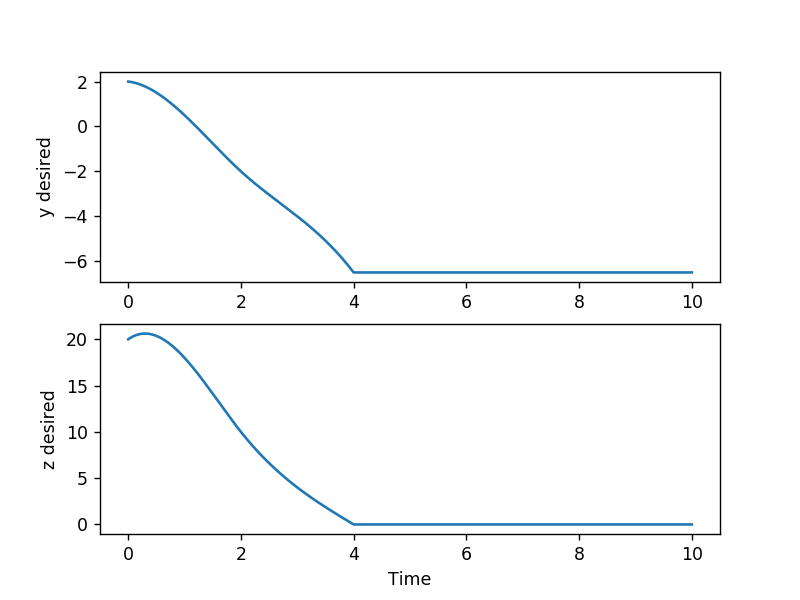

<IPython.core.display.Javascript object>


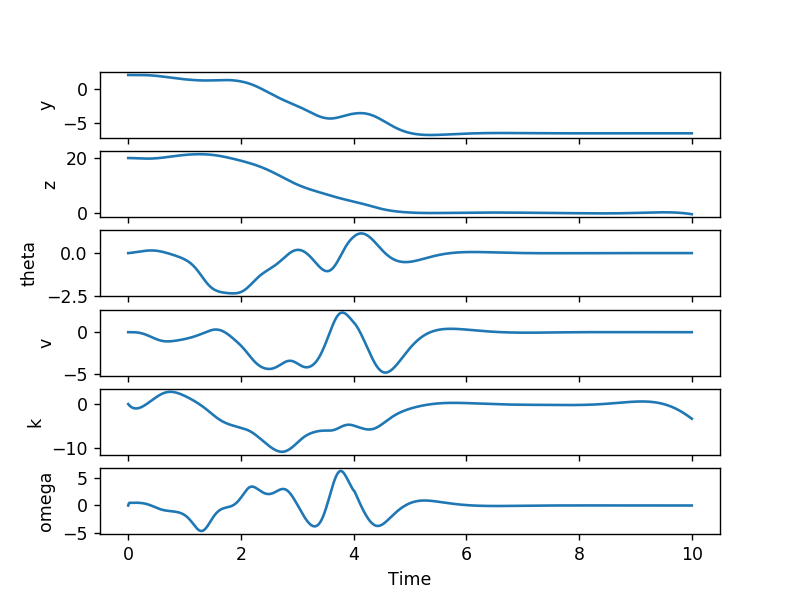

<IPython.core.display.Javascript object>


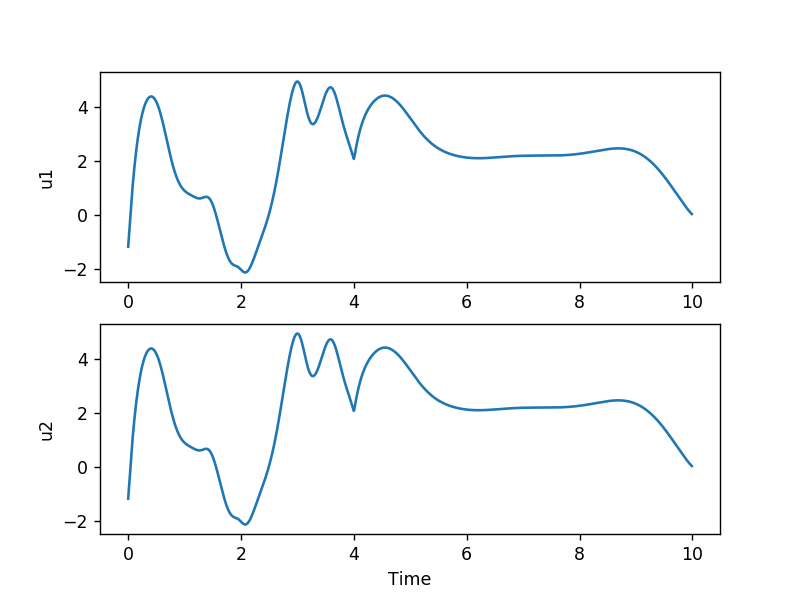

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAyBm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABFgZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMAOjYb3x/yZTrqOgAAAwAHqAFM
AUoCLkL+EFIPgAn7kmwn4iT8oK6u9Ddz3VZkEL90L8QW50sp2FnXOtiP+8Kw0sy2fXt43m4uAM58
XOiRzE9ZBJhzfX4iWQzFr/B/wcF5Jrbr7+321wZAcGczZ3kNBddfwAfLqxS4uSLsK31QPHIW9Id3
yfvO83yvxLtu9gZMVy8nfFny7pV4sN3Z5r3ib0TXghp9c7yNVvAav2TM9T4gcVj1qAvpGIzoh5oU
19fiSZG1dyglxgh+XF0wJs8G7iDMnT3pOl29O7/y8N//2eZUTtqxnCXok7HS0MjkNgWLs+6WD/xn
R3jKqT3iaOqpvP1cIkG3raSX772q+pacW9QWudirIN3BHcuvez2nv8dARq6SOQ0z5YOVMpOi/ssG
5wUIosWlYH+8nQ1XYRe6FlJwS7zPmm7/Gv/w+coR9FZpCBoT8moiMcIELEY3IRFJW/3o2erYcbcN
mVrvDD3ro4omvmCsgyEpb85t3zneaDEhf883EjhGcGSCzaWrMj4qKgvMHbolViLxPO5ySmkUrmxP
7OAFQ6ubNsurIEn8BOaeHVDISUz/yLcSBYcZ4R3muAAGSDMhj33+UThe8GgtuzWJPho5PBW7+e76
26sSO+euFIpPgE7DnNLD+QG/X6aeDP4yljKdnQwicYOd6dP7m4KFVSyRi84hwKMV+j0aIfQg8Fe8
CLftlJH0exyhDesB1HWpZhKiAH/H1Ow02GdEa44ofLnrSbm80PI9994pLZz1ZSPJ2jj5lKXcWqnZ
ZEN3yk8tXPdf0Gu/Un5YRjgHQaXb/+b0vD+16MNaayCKipeLBVi0rqV6Qp6X89iXWOh2pZOi6V6e
KlqEMlEn/a+QIXyj1DhSnpfQQVehHPAQ2o6POgjkX7R7FI//dlkLje18JIDgXJXjnsrLxoMfDP5n
RsFzCbKkplGNe2iU+U1vtyYAwqaif/H8ZaFxpIehHAeHi649bB+MaUz5o0Es2+nKXLJhmgixJojM
6HzQoqi8dQp0C49H0UAAAC4AxgXUzP4wMRRfS7uiAzoZZXycNteJrFLuzOqgjedDpLobxkGohp0w
zsfhUABHvf8MQjks96eIE5bl2prOThyxauaucaKNfLgJp90rVJCqRdBRqST/TNFwWUnkFym8IRRZ
xxCv41dVpeivC1pflGt0q1W9V1LDAVr+tnu6cm5eMx6eIrr8py84zZ3KxQizPu7WcM2bFk9bXZhD
LLVklbafkzaisdCnkRBkPZpVbyR3GuOhrN4Cw3UHdYQNz5cwZpVFEF1KCnPzFQPQfHJWaicu+3sD
hvNHVPGFn+I2b7ZTNqMnjx05LRIXwrW2aM/ulGXixtaQB/dBAM+L/ugJhDOlFIvvrk5Pp5O5p6BO
5r789lNRKB4R0IujI8936WNb3yipu+te56BVoqc38682b1D1uQqoqKh+/qpAbaNGv7jGkAAAAwAA
AwAAAwCojme/Bf6J7CbFlkxKikk4WrFweRL8Gq13pe2Ju55put2iGZr+1K8WKjpQ9ipP6FtXd51i
KXaSflizTKQwOhwPYoTEQvvMpkZ4e+QG8Zou9MI8ZN+eB5SSRXQS5tDbo3wHFitiq6cwCqVLm9EU
qPsEAw4Xd1Ghtiwg+0Cp7hU8AfThu678WiclymZqa4Feq1I8NblMRkgzO/TTygp1YOEiyk2O7V5q
IbP43+d2LXisU0so1irQI3ru4MY5K5Ea+WChU1qGWpsKdLOmvwfjqqyRF96UvvUq8EZv+6NJhimn
N9aptFBr3TqRAuO6LqKKwBI4pGPamenTbdO5r70G8M/FN8h9a/SMgknu6DkkRpyk3fJ0HaOOPyaC
Sl1OjRwx7iz8NRqFz1P/xGieAAADAAADAAADAPX+jFHCsY5/O2uXZa/lKSSRTU4ZpK3KqWmcHRol
Fq2QWxSSMwjWjYXoCABZ8yYrlIn49XUwzQCtA1YYlazQwW0N/K0UReeN3QhjwsvMX7bKfQFPzoAd
tM0hQwI0CyFK4DDUk7TbgT3RNG+LfSR7vWQbheAUsxtq+spVz/dDg8HSaLGW8S5d1iNkm3nrSZjN
p9USrhU4HrQ4Cz25TAOTXwipgspINYLTVuYJtVsq7bsc8cmLILrNrXgUhvtF/F36zz0/b9qWqcBQ
Q5ccr4lFsstwzVy+MRpXNJMg9n+Mcf65B9EoFeP/5/B3VpzHu01dUI9ng0twssTjwThDIRZDxGAX
NpoGU/KidLlwf5RQZetrs5wd05sAcgc0uD6n2PQYQ0y0y3gQ1ocIwYl6CQE2eGBXW/Axc6l914tM
r2z+t7cUfXzwa24cqP2tGQMLh3rz490LM5l4hd4jz0PSwpzcnXN/QgoWGe/UaLRgvMMWYXmFbsU1
nGZEEnfp0eEr8ojO2SlhVbPBbS1WEXDN4ch8ImKHYZfjNqVnGkXUBsq2Hq++C0++tZaYrTxPQX0p
4TeqlAZgU7yVOZxGMsK5RPtvATv8W6AeDZjtDjkGEvIGC9uTVLADhu4wTOifdv0Shfko5A9EoUWj
R3+uSjjS8DIqaIZJd/oGAO5Mxkq+ieSH4IqVb1X7b6Ok9WdEU0G1P4o1e8bEhmSbnX5C/XGfMxYN
D7Kn8+CHbbiB3HnHVCv3fx/QKD7ckc61bdt/CSgkVXaIhu17n3MyEa5ko+hDSvekViVnQFC030QX
jELcpWo5D7V8vrX8SX6uftH4pPCOdMek9zNZfaC8sZTH6FyxPNRUGHfqVEniZFNfZ7YS2u5L2Je8
IsaTSpbqW1jKTqEAAJ6NeKVutQAAAwAQQAAACYUtTrVZyjt3DDgpHprQhOf2v/HT7H0Z1Nw3xxTu
mhYhwAiw7s5ppyRO2xZgm

In [22]:
y_temp,z_temp = trajectory([0,1,2,3,4],[+2,+0.5,-2,-4,-6.5],[20,18,10,4,0],'cubic','cubic')
t1 = np.arange(0, 4, 0.01)
z_1 = z_temp(t1)   # use interpolation function returned by `interp1d`
y_1 = y_temp(t1)   # use interpolation function returned by `interp1d`
t2 = np.arange(4, 10.01, 0.01)
y_2 = np.zeros(np.size(t2))
y_2.fill(-6.5)
z_2 = np.zeros(np.size(t2))
z_2.fill(0)

t = np.concatenate((t1,t2))
z_desired = np.concatenate((z_1,z_2))
y_desired = np.concatenate((y_1,y_2))
plt.figure()
plt.title("desired trajectories")
plt.subplot(2,1,1)
plt.plot(t,y_desired)
plt.ylabel('y desired')
plt.subplot(2,1,2)
plt.plot(t,z_desired)
plt.ylabel('z desired')
plt.xlabel('Time')
plt.show()

horizon_length = 1000
x_desired = np.concatenate((y_desired.reshape(horizon_length+1,1).T, z_desired.reshape(horizon_length+1,1).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T,np.zeros((horizon_length+1,1)).T))

A_f = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -quad.g*quad.dt, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
B_f = np.array([[0, 0],[0, 0], [0, 0],[0, 0], [quad.dt/quad.mass, quad.dt/quad.mass], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])

Q = np.diag([20, 20, 0.1, 1, 1, 5])

R = np.diag([100, 100])


P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations_init(A_f,B_f,Q,R,x_desired, horizon_length)
# we simulate the cart pole and display its behavior
z0 = [2,20,0,0,0,0]

horizon_length = 1000


x_guess,u = quad.simulate(z0, finite_horizon_controller_init, horizon_length)


for h in range(20):

    P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations(x_guess,u,Q,R,x_desired, horizon_length)
    x_guess,u = simulate(x_guess,u,K_FH,k_FH)

x = x_guess

t = np.linspace(0,quad.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.title("states")
plt.subplot(6,1,1)
plt.plot(t,x[0,:])
plt.ylabel('y')
plt.subplot(6,1,2)
plt.plot(t,x[1,:])
plt.ylabel('z')
plt.subplot(6,1,3)
plt.plot(t,x[2,:])
plt.ylabel('theta')
plt.subplot(6,1,4)
plt.plot(t,x[3,:])
plt.ylabel('v')
plt.subplot(6,1,5)
plt.plot(t,x[4,:])
plt.ylabel('k')
plt.subplot(6,1,6)
plt.plot(t,x[5,:])
plt.ylabel('omega')
plt.xlabel('Time')

plt.figure()
plt.title("control u")
plt.subplot(2,1,1)
plt.plot(t[:horizon_length],u[0,:])
plt.ylabel('u1')
plt.subplot(2,1,2)
plt.plot(t[:horizon_length],u[0,:])
plt.ylabel('u2')
plt.xlabel('Time')
plt.show()

animate_quad(x, quad.dt)


In [23]:
## Obstacle Avoiding given trajectory

<IPython.core.display.Javascript object>


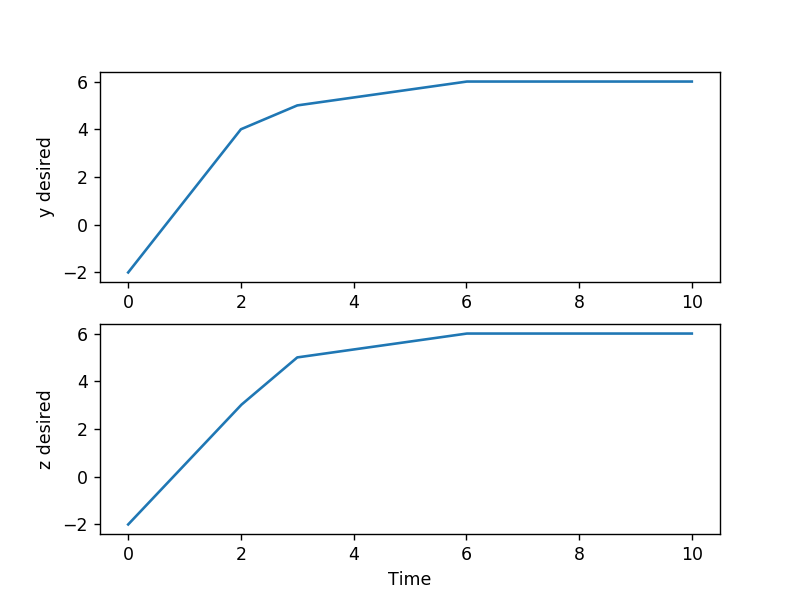

<IPython.core.display.Javascript object>


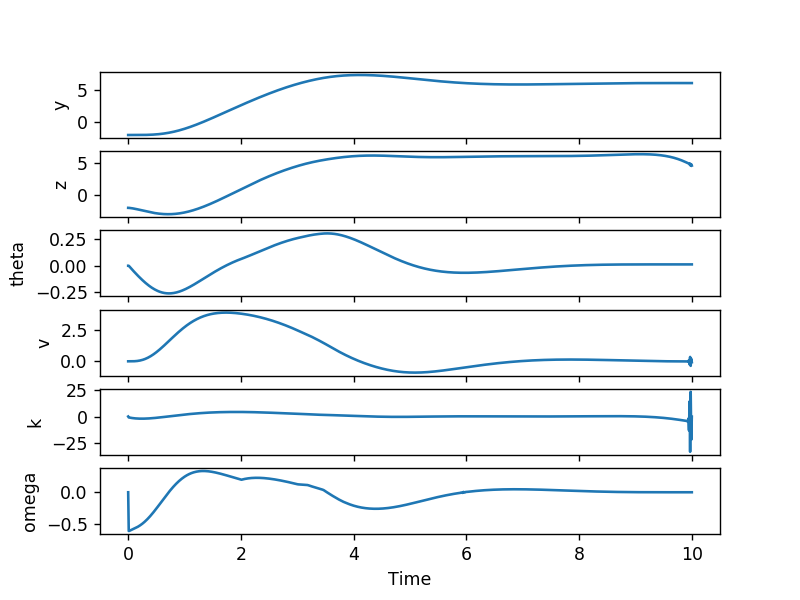

<IPython.core.display.Javascript object>


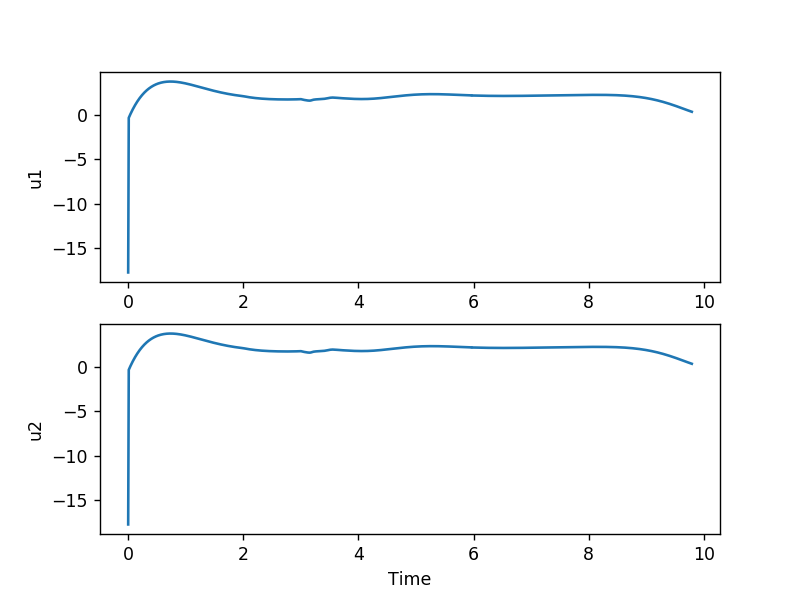

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA8Om1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABTYZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMAIsKw7F+FHM5qOgAAAwAHoAFu
AYEC/Yr8IKGuID1b2meMm54X6fMUy4G4ez04Qv3QvxBbnSynYUdc20rB+wrDSzLZ9e3jebi35LPD
8uRbOoTMHy00ql6j+Zle49E/Tm41pEon0UcBnA4n0M5mzvIaC66/gA+XtmB5eEXYVvqiziFEvdyG
/BRP04/Z6aKyUFm272BkxXLyd8WfLuIjiw3dnmveJvRNeC7kU3eGpP0KGTx8DUes1OGW9PHX/Ga6
IeaFNfX4kmRtXXrLrzHVaES3X6eSSF1tbp70nS7eNfuEPKRDNnmVE5ODEy1g8OUjxDI5DX8REPql
g/8Z0d4yqk9L3zC8YrG1ILX/2Mtg53tV9S04t6ghKeVGxTUEdy697Pae/koN5Yi6fy6HWZwK1FwT
BBpLqDU87FpWB/vJ0NU14y01W9G5k8z5pu/xq/8DnKEfRS4K6blEVr7T3puCxGNyERSVn90Nnq2H
K1pLSvnw+y0bGO5si+zg9aylvzm2EVNf55FIqZn5TwXthkgs2lqzI+KiHkTDLJd2/b+5y/lFF6Pf
LiNcsKjk2Yw7/Xv3ANKvG2WrAtKUrW8pKzRjurTU8rj1CnXCVA0KVM+Jcrfwms6VaD3Vs1iT4aOT
wVu/nu+tmrEjvnrhSKT4BOw5DSw/kBv1+mngymMpYynZ0MInGDnbpT+5uChVUskYvOIDeeZvY7Sy
+STf2mN8j7rCY4d6fQIvbMRogEaw/RR0t5Won0NNhnQ+uOKfy560i/kADcRLvFJbOerKR5O0cfMp
K7i1U7LIhrjo3Mg7f9vLv1J+RUA3+ahb1SpVoGyBzl/a9GGtNZBFmQUPt0ylIN4Tt7JCtMQ+5mw3
9ER/1Daj7ZsIgx3/7OipQQ9VsWnyBNwtsOe4xZkB7WthrFYphSMHpyS2QzNVL6N9O6t+4wsFqX/u
aoIzka3kyIuv+ffAO+1/mrZEwbPWbAChxPnvm7FDkB26zxU1E/x325/3HwetpGph7FxxHRLF9yLb
mLCMpJeW7liVyM1fcsdsuwbL1BPp5M4oEpiAACyWqHBMbEAAAXZK7kABmAYFJf+ZHJfW92srSKrg
UWy0jmbliKd4uzOqgjedDpLobxdn6TZJoZiACmHE1wzj4BXzwhdHwW/x0JdL1IB5E8AZ53LtTWcn
DlUa0ND6/IG+ysrht6NYsM+u0CGLJJrfvzcFlJ5BcpvCEUWcaLfnYS/hza7CkoNEo1ulWq3qupXg
p3b8U9q9NRTvGMQcoK7tBToNNncrFCLM+7tAg+XJJX5ABvVuEZdOJ2d8mbUVjoU8iWDr7cpH6QYz
ZxrR5oda9m+V2NqEPAiFg+rOzdsVT7lTJfpgEu9ppdQLeWqY7c4Ws+jxhmazrf//uKNDoATrYpZK
UErBFv9hRV6lwVeex05+fV1VFqGPsOjgypD81fbJ9kemORAdq5X7dA9Biii6ebtJxIG8CF3SMNGm
2e2tOri8azYweJXTZOygB596ZpPsOtGZ3wYe/RtvmTEntKkMJU8ibyfQ8tibTQXwFrymFMHntt45
rhUrdWrFweRL8Gq1zeLpdJBGjPq06WQKCsnEqLHSh7EronpYtutOlRk0xMhbYoirzigqEP0ALqsS
36dk5QnByRv7QJ+EMz/G/xY2VXakyIj9vTwSPCZLRdU8N7pVcFea9VZwGKCZ3v2ruUXnNihLrqs3
BHJ5M8nFUKr6ufzb3uLnInLp9yPDW5TDCXMvD9QYPWldI4S/cEVVJBN+zXfiejvvQVtibLo4pgzZ
GXGb8kSMmWpm07d4pgiMlLoVCWdLAfU//o6eb3pzzFozKCnpbv/VkvuFPuIMwExA2FJzYp+68hEP
ns/2/4XcO1yBthb4LPPOrVzXHssbsPVTDDZwo71rTq1+hfw0vSv9EaYsAAAesZ/Z5woggq0MFRrc
quXC2AUXqkiOuijXage6yjcDOYKeO7WXjBaGWtBYNQQgd8J057wb3ckLWkk4raVY9iUm4H1+39xf
O7xDJEZTo+Hqwq4if7SEmJyLp8qfQmXAUQPg2jgtH8iEe71n5WRvVhkUJRKzJN7f70wVcYLwjuQd
yW/FT4y4K+0XYtAjYYhPbWNh/CpVfGkO0J6I2VjAaB8TbF3aLKT/IiKE87RA4mYO4QLKDmmDaoIE
xCL1v1B7dfWyEMaxP3+6tttjXWjZGjADY+LCB1mRrXDfCkKe3iw94UzswOthNPi2yLr9jKhhFEQ6
sBqzHM1nx9c4fPb24o6lQjEM4PssYHfSYDv21QfVprpO4ZmYPm6Df5Afc6TFXiF0JTDr3nlg4glZ
xoM/Ifb468tajP1E4zGGt1saPvufBYQaNy6kPoSZ7/kr9dyXsSqRbBQ7E8rpkxwk0AA2nFEh+QQW
u4JC+mrvoGtICIZLreUQ1X7iUTut/+WHb+2SQ4Z5viBj3O8dlBoB+DNbD6vU2In6m5StDfS7QIjr
VrNiAPKaqfacte2ZqCn7kjPWsExGbZxlZPMbxr0z8wsirRhqB3EhF79hxg4cdDHr8HGAYxQmWktk
XZTDbcSb6fZ20VprWQ5XDTSvqlYFFGZW1HH9Y1z/XnCiV8zDICizPxmkrb9pTyZHdL9Is0BMTlEP
u1KDqv+FNjgKMdRNG8vfBNN5Fvo7F7tCfSkBJ372Pae8PfTgLVm9t0HROuVWYsZ7xNkQajH5KbCZ
qq1+c346dGR9s6VHObxBN1ekQNMr8ZgOh5i/oniZuHOIrYTFP7dJ9whFnE/NbDL4O77XC5rW+sTz
4lq2JGotUOcBEdLckd3OM/RnEWWDOlZRTKpDQlX88ieqy9U8AxiSUbi6BFFiZ3zF5I62dp7KE9dd
p/a2Jiw3NbilRuM/CJHd+

In [24]:
#generate trajectory
y_temp,z_temp = trajectory_autoGenerate([0,2,3,6],[-2,4,5,6],[-2,3,5,6])
t1 = np.arange(0, 6, 0.01)
z_1 = z_temp(t1)   # use interpolation function returned by `interp1d`
y_1 = y_temp(t1)   # use interpolation function returned by `interp1d`
t2 = np.arange(6, 10.01, 0.01)
y_2 = np.zeros(np.size(t2))
y_2.fill(6)
z_2 = np.zeros(np.size(t2))
z_2.fill(6)

t = np.concatenate((t1,t2))
z_desired = np.concatenate((z_1,z_2))
y_desired = np.concatenate((y_1,y_2))

plt.figure()
plt.title("desired trajectories")
plt.subplot(2,1,1)
plt.plot(t,y_desired)
plt.ylabel('y desired')
plt.subplot(2,1,2)
plt.plot(t,z_desired)
plt.ylabel('z desired')
plt.xlabel('Time')
plt.show()

horizon_length = 1000
x_desired = np.concatenate((y_desired.reshape(horizon_length+1,1).T, z_desired.reshape(horizon_length+1,1).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T,np.zeros((horizon_length+1,1)).T))

A_f = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -quad.g*quad.dt, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
B_f = np.array([[0, 0],[0, 0], [0, 0],[0, 0], [quad.dt/quad.mass, quad.dt/quad.mass], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])

Q = np.diag([30, 30, 0.1, 1, 1, 500])
QN = np.diag([30,30, 0.1, 1, 1, 500])

R = np.diag([10, 10])



x0 = [-2,-2,0,0,0,0]
x_obs=[]
x_obs.append([0,0,0,0,0,0])

horizon_length = 1000

#Solve LQR to get initial guess
P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations_init(A_f,B_f,Q,R,x_desired, horizon_length)
x_guess,u = quad.simulate(x0, finite_horizon_controller_init, horizon_length)


#Solve ILQR
gamma = 30
rho = 1
for h in range(10):

    P_FH,K_FH,p_FH,k_FH = backward_pass(rho,gamma,x_guess,u,Q,R,x_desired, horizon_length,x_obs)
    x_guess,u = forward_pass(x0,K_FH,k_FH,x_guess,u,x_desired)

#plot results
x = x_guess
t = np.linspace(0,quad.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(6,1,1)
plt.plot(t,x[0,:])
plt.ylabel('y')
plt.subplot(6,1,2)
plt.plot(t,x[1,:])
plt.ylabel('z')
plt.subplot(6,1,3)
plt.plot(t,x[2,:])
plt.ylabel('theta')
plt.subplot(6,1,4)
plt.plot(t,x[3,:])
plt.ylabel('v')
plt.subplot(6,1,5)
plt.plot(t,x[4,:])
plt.ylabel('k')
plt.subplot(6,1,6)
plt.plot(t,x[5,:])
plt.ylabel('omega')
plt.xlabel('Time')

plt.figure()
plt.title("control u")
plt.subplot(2,1,1)
plt.plot(t[:horizon_length-20],u[0,:horizon_length-20])
plt.ylabel('u1')
plt.subplot(2,1,2)
plt.plot(t[:horizon_length-20],u[0,:horizon_length-20])
plt.ylabel('u2')
plt.xlabel('Time')
plt.show()

animate_quad(x_guess[:horizon_length-20], quad.dt,True)

In [25]:
## Obstacle Avoidance give start, goal and obstacle location

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


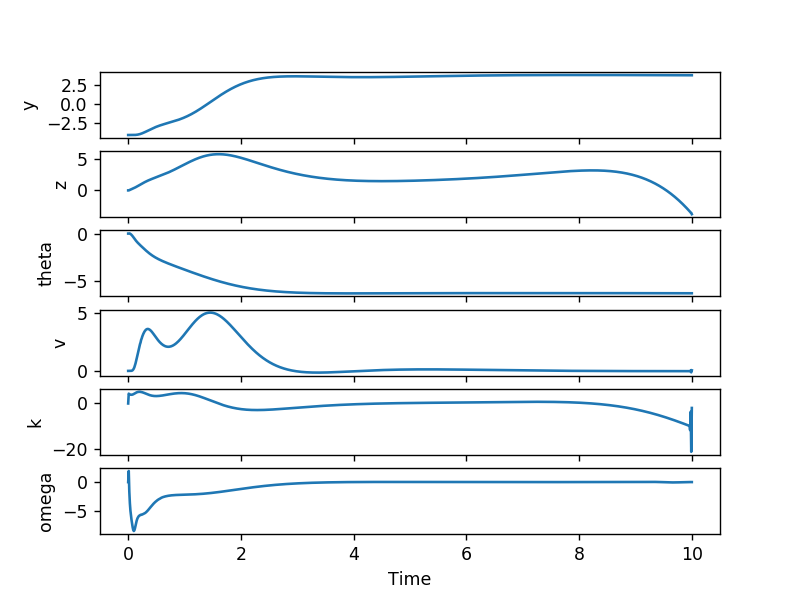

<IPython.core.display.Javascript object>


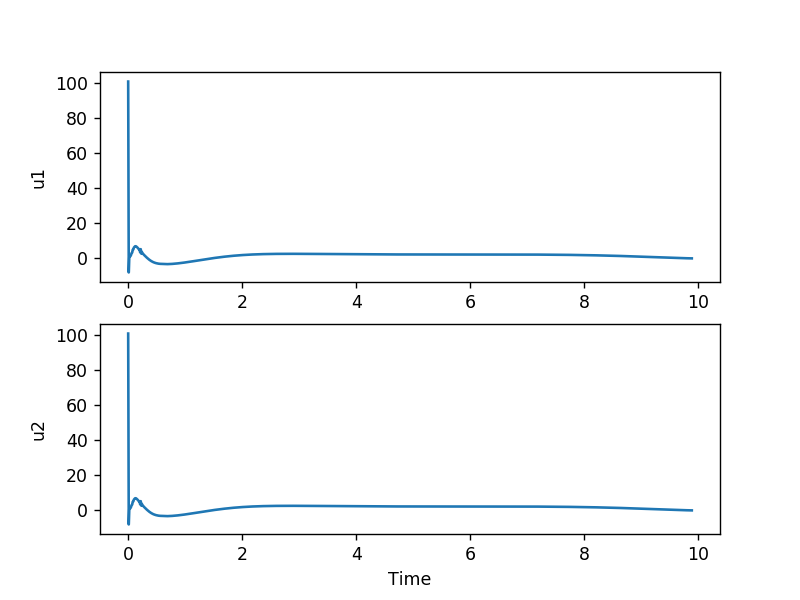

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA8QW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABTAZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMAOjYb3x/yZTrqOgAAAwAHqAFM
AUoCLkL+EFIPgAn7kmwn4iT8oK6u9Ddz3VZkEL90L8QW50sp2FnXOtiP+8Kw0sy2fXt43m4uAM58
XOiRzE9ZBJhzfX4iWQzFr/B/wcF5Jrbr7+321wZAcGczZ3kNBddfwAfLqxS4uSLsK31QPHIW9Id3
yfvO83yvxLtu9gZMVy8nfFny7pV4sN3Z5r3ib0TXghp9c7yNVvAav2TM9T4gcVj1qAvpGIzoh5oU
19fiSZG1dyglxgh+XF0wJs8G7iDMnT3pOl29O7/y8N//2eZUTtqxnCXok7HS0MjkNgWLs+6WD/xn
R3jKqT3iaOqpvP1cIkG3raSX772q+pacW9QWudirIN3BHcuvez2nv8dARq6SOQ0z5YOVMpOi/ssG
5wUIosWlYH+8nQ1XYRe6FlJwS7zPmm7/Gv/w+coR9FZpCBoT8moiMcIELEY3IRFJW/3o2erYcbcN
mVrvDD3ro4omvmCsgyEpb85t3zneaDEhf883EjhGcGSCzaWrMj4qKgvMHbolViLxPO5ySmkUrmxP
7OAFQ6ubNsurIEn8BOaeHVDISUz/yLcSBYcZ4R3muAAGSDMhj33+UThe8GgtuzWJPho5PBW7+e76
26sSO+euFIpPgE7DnNLD+QG/X6aeDP4yljKdnQwicYOd6dP7m4KFVSyRi84hwKMV+j0aIfQg8Fe8
CLftlJH0exyhDesB1HWpZhKiAH/H1Ow02GdEa44ofLnrSbm80PI9994pLZz1ZSPJ2jj5lKXcWqnZ
ZEN3yk8tXPdf0Gu/Un5YRjgHQaXb/+b0vD+16MNaayCKipeLBVi0rqV6Qp6X89iXWOh2pZOi6V6e
KlqEMlEn/a+QIXyj1DhSnpfQQVehHPAQ2o6POgjkX7R7FI//dlkLje18JIDgXJXjnsrLxoMfDP5n
RsFzCbKkplGNe2iU+U1vtyYAwqaif/H8ZaFxpIehHAeHi649bB+MaUz5o0Es2+nKXLJhmgixJojM
6HzQoqi8dQp0C49H0UAAAC4AxgXUzP4wMRRfS7uiAzoZZXycNteJrFLuzOqgjedDpLobxkGohp0w
zsfhUABHvf8MQjks96eIE5bl2prOThyxauaucaKNfLgJp90rVJCqRdBRqST/TNFwWUnkFym8IRRZ
xxCv41dVpeivC1pflGt0q1W9V1LDAVr+tnu6cm5eMx6eIrr8py84zZ3KxQizPu7WcM2bFk9bXZhD
LLVklbafkzaisdCnkRBkPZpVbyR3GuOhrN4Cw3UHdYQNz5cwZpVFEF1KCnPzFQPQfHJWaicu+3sD
hvNHVPGFn+I2b7ZTNqMnjx05LRIYmtJDbNDN6UZeLG1pAH90EAz4v+6AmEM6UI86fiZt6/sfSg4p
PmR9s47+8cl28w0b78Jr6N71vfKKm7617noFWipzcTrypvUPW2Mg82qYv/FUxtogc/q7F5gAAAMA
AAMAAAz2RnvwX+iewmvZZMSopJOFqxcHkS/Bqtd6Xtibueabrdohma/tSvFio6UPYqT+hbV3edYi
l2kn5Ys0ykMDocD2KExEL7zKZGeHvkBvGaLvTCPGTfngeUkkV0EubQ26N8BxYrYqunMAqlSz3u6O
GbBAMOF3dRobYsIPtAqe4VPAH04buw/FonJcpmaleBXqtSPDW5TEZIMzv008oKdWDhIspNju1eai
Gz+N/ndi14rFNLKNYq0CN67uDGOSuRGvlgoVNahlqbCnSzpr8H46qsoRfelL70yvBGb+ejSYYppz
fWqbRQa906kQLjui6iXsASOKRj2pnp023Tua+9BvDPxTfIfWz0jIJJ7uh5JEacpN3ydB2jjj8mUk
pdTo0cMe4vgDUahc8r/8RocIAAADAAADAAAR1Fab3QWxz+dtcuy1/KUkkimpwzSVuVUtM4OjRKLV
sgtikkZhGtGwvJGACCyWyzfaLcruYPtlSRb6GDzLFJwtob+Vooi88buhDHhZeYv22U+gKfnQA7aZ
pChgRoFkKVwGGpJ2m3AnuiaN8W+kj3esg3C8ApZjbV9ZSrn+6G34Ok0WMt4ly7rEbJNvPWkzGbT6
olXCpwPWhwFntymAcmvhFTBZSQawamrcwTarZV23Y545LWQXWbWvApDfaL+Lv1nnp+37U+ZHjfUx
wNgA9b+gCQ0hqsIfdU0DbrVyI0p92v+uQfRKBXj/+fwd1acx7qGsNqBJ4NLcLLE48E4QyEWQ8RgF
zaaBlPxDu+otL3tsB9uvrOcHdObAHIHNLg+p5D0GDZMtMt4ENaHCMGJegkBNihgVAMeDvlGW5UDT
K9s/me2OX8SuHpW81H32gYEln7NF8e6MlHhg6Sa+eqo1Mc//gryOJXWsbdGngJ2wfnkcyU/vOWeR
7K6nphPBxZjj+TMqo+3dE+F8RaKGYXxfozZdrvfktVhvPo47BPz+xO3/5z/RJBiPvucn0PXv2HF/
6RHdl+tjnHQRMu92+KoT9zltyjZaVhXXnobcfSp0YRJdJ2xwj/BM/06KDnfOG0r5mGQXOJ5NN7c7
5pypT3VGQz65LM3HYfoESnVf8KpgWUqMCY3H4GO9LATHvUk2C3eR10B5vjvVf5VDpvvsS/4ySUNJ
PUYkJnn8Od1XC8YTNV0OhfXdrq+raxTD5zut86TAuwe/PGYReZa58A8TNw5xFjwjnHHf4zgv5buj
rYZfB29iyS36h8VMLJpV390bUJsbW8SOdLgVmWOiyeQv9KfV3poGI6gd9WJ5c+56U0JbVk9f+Fwd
2KPw+262dp7KWVO4/+1sTFhua29Ea/ZTLeRqVryZrj+RUwTOqf/zYljHyd+2avtw97pwjmU9gQl1
sChPRRN8FBUThrRjh3ocB

In [26]:
y_goal,z_goal = 4,2
y_start, z_start = -4,0

travel_t2 = 10


x_obs=[]
x_obs.append([0,0,0,0,0,0]) #obstacle at (0,0)

quad = Quadrotor()

horizon_length = 1000
horizon2 = int(round(travel_t2/quad.dt))
y1 = np.zeros(horizon2+1) 
y1.fill(y_goal)
z1 = np.zeros(horizon2+1) 
z1.fill(z_goal)
x_desired = np.array([y1,z1,np.zeros(horizon2+1),np.zeros(horizon2+1),np.zeros(horizon2+1),np.zeros(horizon2+1)])

x_start = np.array([y_start, z_start,0,0,0,0])

A_f = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -quad.g*quad.dt, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
B_f = np.array([[0, 0],[0, 0], [0, 0],[0, 0], [quad.dt/quad.mass, quad.dt/quad.mass], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])


Q = np.diag([20, 20, 0.1, 1, 1, 1])
R = np.diag([100, 100])

P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations_init(A_f,B_f,Q,R,x_desired, horizon2)
x_guess1,u1 = quad.simulate(x_start, finite_horizon_controller_init,  horizon2)


Q = np.diag([20, 20, 0.1, 1, 1, 500])
QN = np.diag([100, 100, 0.1, 1, 1, 500])

R = np.diag([100, 100])

gamma = 1
rho = 1
alpha = 1  
for h in range(5):
    P_FH,K_FH,p_FH,k_FH = backward_pass(rho,gamma,x_guess1,u1,Q,R,x_desired, horizon_length,x_obs)
    x_guess1,u1 = forward_pass(x_start,K_FH,k_FH,x_guess1,u1,x_desired)
    
t = np.linspace(0,quad.dt*(horizon2), horizon2+1)

plt.figure()
plt.subplot(6,1,1)
plt.plot(t,x_guess1[0,:])
plt.ylabel('y')
plt.subplot(6,1,2)
plt.plot(t,x_guess1[1,:])
plt.ylabel('z')
plt.subplot(6,1,3)
plt.plot(t,x_guess1[2,:])
plt.ylabel('theta')
plt.subplot(6,1,4)
plt.plot(t,x_guess1[3,:])
plt.ylabel('v')
plt.subplot(6,1,5)
plt.plot(t,x_guess1[4,:])
plt.ylabel('k')
plt.subplot(6,1,6)
plt.plot(t,x_guess1[5,:])
plt.ylabel('omega')
plt.xlabel('Time')

plt.figure()
plt.title("control u")
plt.subplot(2,1,1)
plt.plot(t[:horizon_length-10],u1[0,:horizon_length-10])
plt.ylabel('u1')
plt.subplot(2,1,2)
plt.plot(t[:horizon_length-10],u1[0,:horizon_length-10])
plt.ylabel('u2')
plt.xlabel('Time')
plt.show()
animate_quad(x_guess1, quad.dt,True)

(6, 1001)


<IPython.core.display.Javascript object>


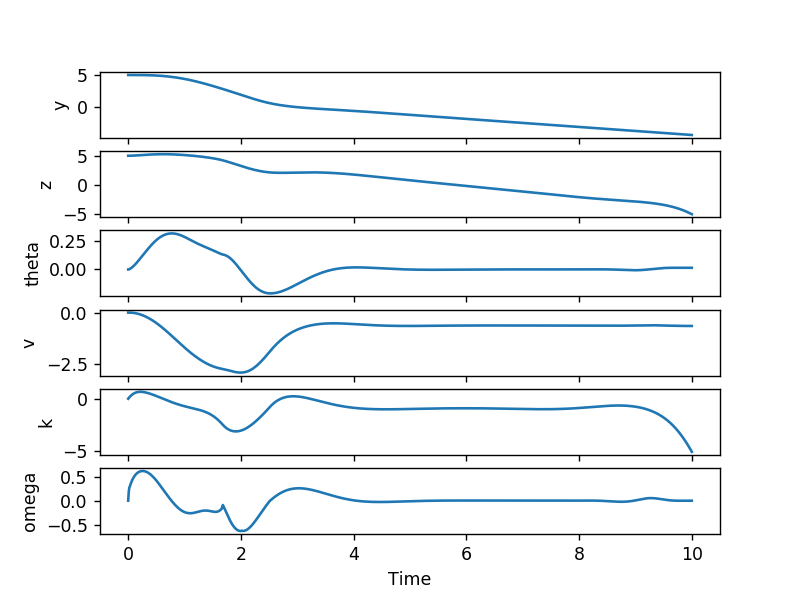

<IPython.core.display.Javascript object>


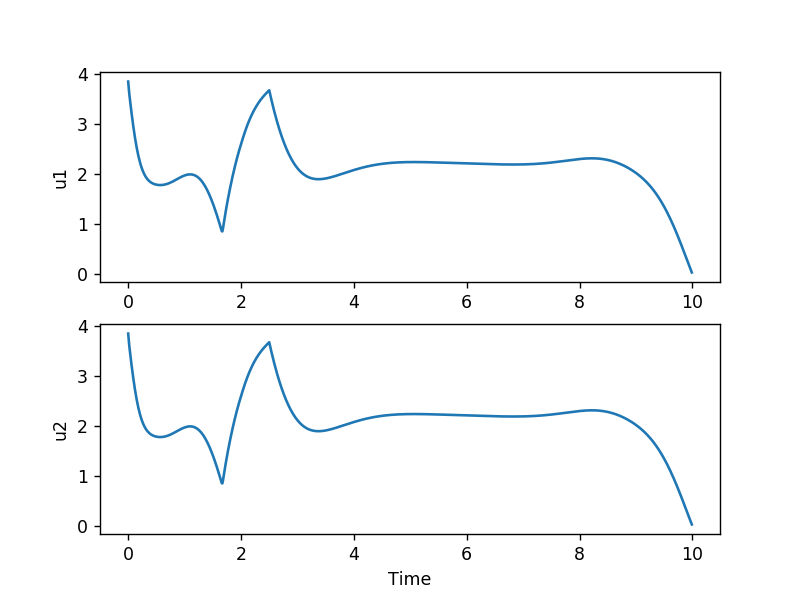

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA3om1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABIAZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMAIsKw7F+FHM5qOgAAAwAHoAFu
AYEC/Yr8IKGuID1b2meMm54X6fMUy4G4ez04Qv3QvxBbnSynYUdc20rB+wrDSzLZ9e3jebi35LPD
8uRbOoTMHy00ql6j+Zle49E/Tm41pEon0UcBnA4n0M5mzvIaC66/gA+XtmB5eEXYVvqiziFEvdyG
/BRP04/Z6aKyUFm272BkxXLyd8WfLuIjiw3dnmveJvRNeC7kU3eGpP0KGTx8DUes1OGW9PHX/Ga6
IeaFNfX4kmRtXXrLrzHVaES3X6eSSF1tbp70nS7eNfuEPKRDNnmVE5ODEy1g8OUjxDI5DX8REPql
g/8Z0d4yqk9L3zC8YrG1ILX/2Mtg53tV9S04t6ghKeVGxTUEdy697Pae/koN5Yi6fy6HWZwK1FwT
BBpLqDU87FpWB/vJ0NU14y01W9G5k8z5pu/xq/8DnKEfRS4K6blEVr7T3puCxGNyERSVn90Nnq2H
K1pLSvnw+y0bGO5si+zg9aylvzm2EVNf55FIqZn5TwXthkgs2lqzI+KiHkTDLJd2/b+5y/lFF6Pf
LiNcsKjk2Yw7/Xv3ANKvG2WrAtKUrW8pKzRjurTU8rj1CnXCVA0KVM+Jcrfwms6VaD3Vs1iT4aOT
wVu/nu+tmrEjvnrhSKT4BOw5DSw/kBv1+mngymMpYynZ0MInGDnbpT+5uChVUskYvOIDeeZvY7Sy
+STf2mN8j7rCY4d6fQIvbMRogEaw/RR0t5Won0NNhnQ+uOKfy560i/kADcRLvFJbOerKR5O0cfMp
K7i1U7LIhrjo3Mg7f9vLv1J+RUA3+ahb1SpVoGyBzl/a9GGtNZBFmQUPt0ylIN4Tt7JCtMQ+5mw3
9ER/1Daj7ZsIgx3/7OipQQ9VsWnyBNwtsOe4xZkB7WthrFYphSMHpyS2QzNVL6N9O6t+4wsFqX/u
aoIzka3kyIuv+ffAO+1/mrZEwbPWbAChxPnvm7FDkB26zxU1E/x325/3HwetpGxkEA2HU4jiFrXR
NXMWEZSS8t3LErkZq+5Y7ZdgsQfbUvLleFaA0AAF2G6uOyEQAAAamoggAaQIqEv/Mjkjre7WVpFV
wKLZaRzNyxFO8XZnVQRvOh0l0N4uz9Jsk0Mw8WAKSa4Zx8Ar54Quj4Lf46Eul6kA8ao63JElrLO0
2hyqNaGh9fkDfZWVw29GsWGfXaBDFkk1v35uCyk8guU3hCKLONFvzsJfw5tdhSUGiUa3SrVb1XUr
wU7t+Ke1emohXjGIOUFd2gp0GmzuVihFmfd2gQfLkkucIA3q19Yo631+wpgXL6N2viPHNbb/SpwY
zZxrR5oda9m+V2NqEPAiFg+rOzdsVT7lTJfpgEu9ppdQLeWqY7c4Ws+jxhmazrf//uKNDoATrYpZ
KUErBFv9hRV6lwVeex05+fV1VFqGPsOjgypD81fbJ9kemORAdq5X7dA9Biln0P9Wv6LFSN/ukYaN
Ns9tadXF41gxg8SumydlADz70x7/QbUlsBXJMo+dvmTEntKkMKgtowHaz0foBhylXqr+VrozXpVt
lt+WwG7LXR/XpsP8NFfMvKij+B4oWqkYfPD89gqMP6o2qTjvkZIGzk5nTn4/zGRdWR+Djw5lcUnR
XARQVKvPEWq5vFKBXsai2bpK7vOsRS7ST8sSeRqcA85Wh+gBdViW/TspoE94mjH4CfhDM/xxmqoL
bZHIr1CAn+x9hMlouqeG+tuHDYo1bE4B3N+UBbUt0LzmxQl246lJQJ5M9fQ6bX4RegHJo5wTkqe+
s47sAivPZ79fvp2A83rBwl+4IqqSZOqtn3S3I6WTVCoRl0cUwZsjLjPTf6rb8iJs4KZqUqxkpdCo
SzpYD7iuGEWLdJG+QtGZQU9Ld/6tQeoHLAvWJ0qmEUfNiy+AQWQiHz2f7f8LsmddXd2l5a12Xltp
1x7IcHCYmN0zc2z21p1bFrKfr5zeEZoMRAC5J5kXpKaur5t3nahutysfEhAIztSRTYCJd/zDMNft
4N/1lZPV9J9kWET2R72NDcnn5Sfk467fQ4Wy2J7FdQsXJTFnzFqGlLIXhEs/NeYrAdCgXUQq8P2Q
o9PEmF7ScPFJwvx9NdI1ZU8Ksa2CEL8cHvnt+3cbLspTTwG0fTjlu02FXFHz7V9Nw5pmJxUqZ3KA
pOFm8q9QfyLzxu6EMeFlS8kr5MWlutB+guteyhTtC/kAQV2EdmOK0RRa6Jo3xb6RrK5UQen0HqGN
tX1WkmPL7Yqxuk0WMte6y6hDrkCcjMi5i/cDyNXEOlQiWQdzUEfUW7EilRMGegfDFM9H+JtdB32m
xidadmr3ZZ+1EL8RFXrfNC5jrEqOWzh128qCAJDU8sh375Ohyq/xHDn7H94I8KN/oIuNYTZytuXa
/BZl0BWwvLuGSDg5P0y7JaFQLUjZmI26m0aF6ZplAV97rEp65sVQkBI1Oc6f7XbDQ85dEfhM8Wmw
QUFHhaGQesGcY6FYIa0OEYM7Wtz2DPOaYbPNGzJI9B+lzRHvYEuHli9nCoDwJSg1s02rvglfU1wk
ElgbeZ+TtYMHefi+n9sGckAVvktBwhdIpWT7ELOPbcCS3WXdjiOTZN+35d8HrXZ9Tr6A5+7eMVlj
r5y9Iioo+ff6kPGIR9C2F1aXfdzsSb/QJW9FDZLSskgyYvuh4llepCjbgGPBC7kcD++tZZ+7DsvL
Jn2sw3yS4lF7CofykTXUDlcofk2+2DeFdAOuLI7Q45BhLyBzNxZxzKhUW9gG1erEX9EoX8sNa9dD
jermQ/jiS7lFcQ8FiZiSTaQeCekFywcsnYhOATTEnNyvu6nkathhnCk6fJ1lF9Qs1ICKn4kEigeh
xXo3p/wAyhijA74gNTHST

In [27]:
##Known Location of Window
y_goal,z_goal = -5,-5
y_start, z_start = 5,5
y_window, z_window = 0,2
t = 10
y_temp,z_temp = trajectory_autoGenerate([0,t/6,t/5,t/4,t],[y_start,y_window+0.25,y_window,y_window-0.25,y_goal],[z_start,z_window,z_window,z_window,z_goal])
t1 = np.arange(0, t, 0.01)
z_1 = z_temp(t1)   # use interpolation function returned by `interp1d`
y_1 = y_temp(t1)   # use interpolation function returned by `interp1d`
t2 = np.arange(t, 10.01, 0.01)
y_2 = np.zeros(np.size(t2))
y_2.fill(-6.5)
z_2 = np.zeros(np.size(t2))
z_2.fill(0)

t = np.concatenate((t1,t2))
z_desired = np.concatenate((z_1,z_2))
y_desired = np.concatenate((y_1,y_2))




horizon_length = 1000
x_desired = np.concatenate((y_desired.reshape(horizon_length+1,1).T, z_desired.reshape(horizon_length+1,1).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T,np.zeros((horizon_length+1,1)).T))
#x_desired =np.array([np.zeros((horizon_length+1,1)), np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1))]).reshape(horizon_length+1,6).T
A_f = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -quad.g*quad.dt, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
B_f = np.array([[0, 0],[0, 0], [0, 0],[0, 0], [quad.dt/quad.mass, quad.dt/quad.mass], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])
#print(np.shape(R))

Q = np.diag([20, 20, 0.1, 1, 1, 5])
print(np.shape(x_desired))
R = np.diag([100, 100])


P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations_init(A_f,B_f,Q,R,x_desired, horizon_length)

z0 = [y_start, z_start,0,0,0,0]

horizon_length = 1000


x_guess,u = quad.simulate(z0, finite_horizon_controller_init, horizon_length)


for h in range(20):
    P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations(x_guess,u,Q,R,x_desired, horizon_length)
    x_guess,u = simulate(x_guess,u,K_FH,k_FH)

x = x_guess
t = np.linspace(0,quad.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(6,1,1)
plt.plot(t,x[0,:])
plt.ylabel('y')
plt.subplot(6,1,2)
plt.plot(t,x[1,:])
plt.ylabel('z')
plt.subplot(6,1,3)
plt.plot(t,x[2,:])
plt.ylabel('theta')
plt.subplot(6,1,4)
plt.plot(t,x[3,:])
plt.ylabel('v')
plt.subplot(6,1,5)
plt.plot(t,x[4,:])
plt.ylabel('k')
plt.subplot(6,1,6)
plt.plot(t,x[5,:])
plt.ylabel('omega')
plt.xlabel('Time')

plt.figure()
plt.title("control u")
plt.subplot(2,1,1)
plt.plot(t[:horizon_length],u[0,:])
plt.ylabel('u1')
plt.subplot(2,1,2)
plt.plot(t[:horizon_length],u[0,:])
plt.ylabel('u2')
plt.xlabel('Time')
plt.show()
animate_quad(x, quad.dt,window=True)

(6, 1001)


<IPython.core.display.Javascript object>


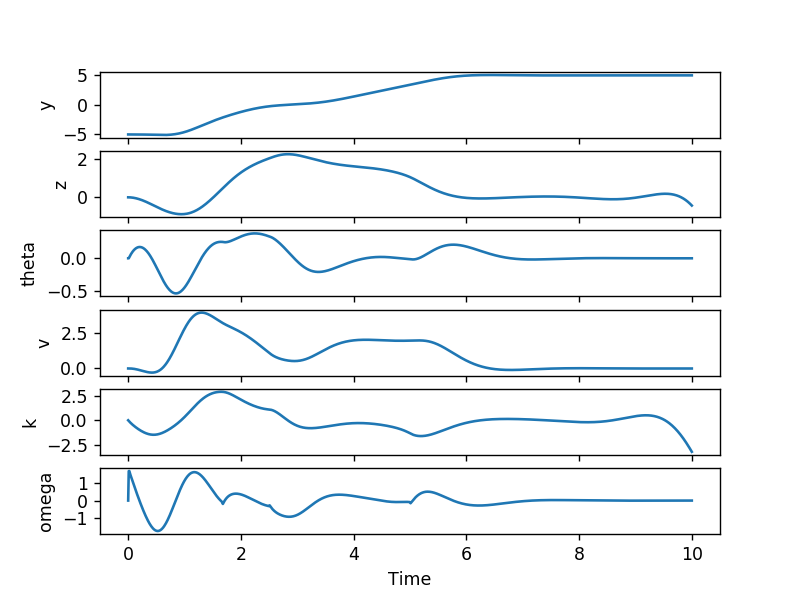

<IPython.core.display.Javascript object>


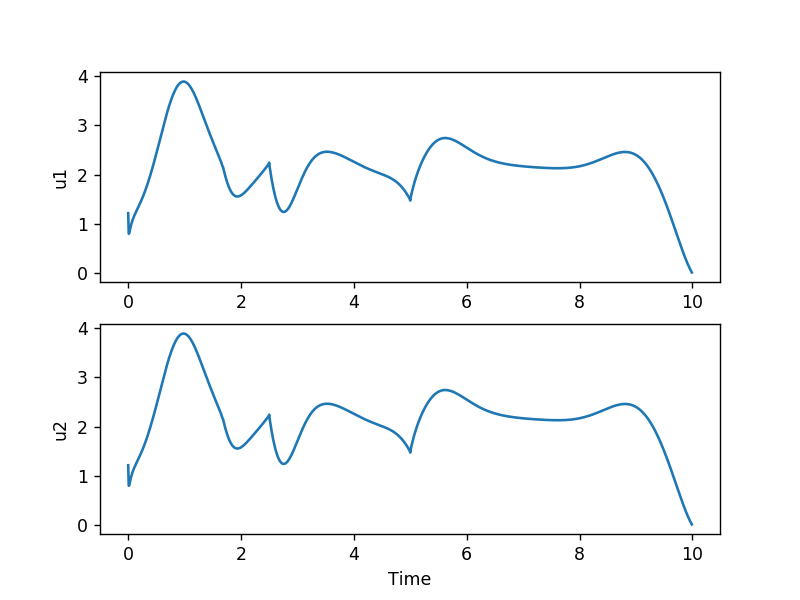

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA5Gm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABHrZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMAIsKw7F+FHM5qOgAAAwAHoAFu
AYEC/Yr8IKGuID1b2meMm54X6fMUy4G4ez04Qv3QvxBbnSynYUdc20rB+wrDSzLZ9e3jebi35LPD
8uRbOoTMHy00ql6j+Zle49E/Tm41pEon0UcBnA4n0M5mzvIaC66/gA+XtmB5eEXYVvqiziFEvdyG
/BRP04/Z6aKyUFm272BkxXLyd8WfLuIjiw3dnmveJvRNeC7kU3eGpP0KGTx8DUes1OGW9PHX/Ga6
IeaFNfX4kmRtXXrLrzHVaES3X6eSSF1tbp70nS7eNfuEPKRDNnmVE5ODEy1g8OUjxDI5DX8REPql
g/8Z0d4yqk9L3zC8YrG1ILX/2Mtg53tV9S04t6ghKeVGxTUEdy697Pae/koN5Yi6fy6HWZwK1FwT
BBpLqDU87FpWB/vJ0NU14y01W9G5k8z5pu/xq/8DnKEfRS4K6blEVr7T3puCxGNyERSVn90Nnq2H
K1pLSvnw+y0bGO5si+zg9aylvzm2EVNf55FIqZn5TwXthkgs2lqzI+KiHkTDLJd2/b+5y/lFF6Pf
LiNcsKjk2Yw7/Xv3ANKvG2WrAtKUrW8pKzRjurTU8rj1CnXCVA0KVM+Jcrfwms6VaD3Vs1iT4aOT
wVu/nu+tmrEjvnrhSKT4BOw5DSw/kBv1+mngymMpYynZ0MInGDnbpT+5uChVUskYvOIDeeZvY7Sy
+STf2mN8j7rCY4d6fQIvbMRogEaw/RR0t5Won0NNhnQ+uOKfy560i/kADcRLvFJbOerKR5O0cfMp
K7i1U7LIhrjo3Mg7f9vLv1J+RUA3+ahb1SpVoGyBzl/a9GGtNZBFmQUPt0ylIN4Tt7JCtMQ+5mw3
9ER/1Daj7ZsIgx3/7OipQQ9VsWnyBNwtsOe4xZkB7WthrFYphSMHpyS2QzNVL6N9O6t+4wsFqX/u
aoIzka3kyIuv+ffAO+1/mrZEwbPWbAChxPnvm7FDkB26zxU1E/x325/3HwetpGph7FxxHRLF9yLb
mLCMpJeW7liVyM1fcsdsuwbL1BPp5M4oEpiAACyWqHBMbEAAAXZK7kABmAYFJf+ZHJfW92srSKrg
UWy0jmbliKd4uzOqgjedDpLobxdn6TZJoZiACmHE1wzj4BXzwhdHwW/x0JdL1IB5E8AZ53LtTWcn
DlUa0ND6/IG+ysrht6NYsM+u0CGLJJrfvzcFlJ5BcpvCEUWcaLfnYS/hza7CkoNEo1ulWq3qupXg
p3b8U9q9NRTvGMQcoK7tBToNNncrFCLM+7tAg+XJJX5ABvVuEZdOJ2d8mbUVjoU8iWDr7cpH6QYz
ZxrR5oda9m+V2NqEPAiFg+rOzdsVT7lTJfpgEu9ppdQLeWqY7c4Ws+jxhmazrf//uKNDoATrYpZK
UErBFv9hRV6lwVeex05+fV1VFqGPsOjgypD81fbJ9kemORAdq5X7dA9Biii6ebtJxIG8CF3SMNGm
2e2tOri8azYweJXTZOygB596ZpPsOtGZ3wYe/RtvmTEntKkMJU8ibyfQ8tibTQXwFrymFMHntt45
rhUrdWrFweRL8Gq1zeLpdJBGjPq06WQKCsnEqLHSh7EronpYtutOlRk0xMhbYoirzigqEP0ALqsS
36dk5QnByRv7QJ+EMz/G/xY2VXakyIj9vTwSPCZLRdU8N7pVcFea9VZwGKCZ3v2ruUXnNihLrqs3
BHJ5M8nFUKr6ufzb3uLnInLp9yPDW5TDCXMvD9QYPWldI4S/cEVVJBN+zXfiejvvQVtibLo4pgzZ
GXGb8kSMmWpm07d4pgiMlLoVCWdLAfU//o6eb3pzzFozKCnpbv/VkvuFPuIMwExA2FJzYp+68hEP
ns/2/4XcO1yBthb4LPPOrVzXHssbsPVTDDZwo71rTq1+hfw0vSv9EaYsAAAesZ/Z5woggq0MFRrc
quXC2AUXqkiOgQTIfp+c/hGLJ/e16F7atxplwk8j3saG5PPyk/Jx12+hwtlsT1y6hYyWstQCcoMH
mQvSRtb5j3cB0KAu/ZxrtI6IoyIZyjRWMYThfj6a6Rqyp4VY6J0IX44PfPb9u5lhPmmnfFr5HHLd
psKuKPn2nY7idTMTipUzuUBScLNpV6g/kXnjd0IY8LKcsDnN++TMJqgHbTNIUMpLHthSuAw1JOzX
q0cWmF5rsCksP22SWufd+FiBRHmVKPL7T2++iysZa91l1X9qy25GZFzF+4LkbGjgRUI8tlZqHT3e
THEY1hqKPUIP84nph4FdozEGE60msXuyz9qIX4iKwX94Fv7QOZDOvdfXyoIAkNTyyKvvk8HKr/Eh
/5E4+LtoBH/+H5hSKoxerUg+yjk/TLS1l06H1i2UfEMHv3TlPZABTn7xfN+xxCQFB2Bzj3qpwuqU
j05YJSxa5XEzkm+MY5MCrO46aEI/C4MSyD6KmbQU5o8kocJzU5yFSDZCiC2eOgUjM/4AMY1LHHDT
eYOCV9V0MVLurmFcbHDn63O/5s1BZQM5IAqVi0H71bLHsn2IWcxGSElusu7HEcmyb9vy74PWuz2s
RxjnLt4xWWOnomyK1Irbj3qQ8YhGR5Qq24d93OxA+aF8gS2RXwiYoKLi+6HiWV6kKNt0ldRz7r2H
99ayz02HZeWTPtZhvklxGwbPyVOZxGMsK5S3sNdsG8K6Ador0BflcGEvIHM3FnH1uGUlxgmdE9Iv
yyhfyw1r10boN6Kj+OJMJhDYn5mGwG6bkg8E9ILlg33uxB4lm9D9k9qNrX0A654jaYjNA//UJyzb
5g9KjfRMkzILlfz93PpiBNas4RTmuYyIOTvuRTSxJYAA7Cumse9/z+Q+sq5PZGj7J677E7krc0QV
lQnUSLn+dqofODNAvcc5P

In [28]:
##if we know the location of the window
y_goal,z_goal =  5,0
y_start, z_start = -5,0
y_window, z_window = 0,2
t = 10
y_temp,z_temp = trajectory_autoGenerate([0,t/6,t/4,t/2,t],[y_start,y_window,y_window,y_goal,y_goal],[z_start,z_window,z_window,z_goal,z_goal])
t1 = np.arange(0, t, 0.01)
z_1 = z_temp(t1)   # use interpolation function returned by `interp1d`
y_1 = y_temp(t1)   # use interpolation function returned by `interp1d`
t2 = np.arange(t, 10.01, 0.01)
y_2 = np.zeros(np.size(t2))
y_2.fill(-6.5)
z_2 = np.zeros(np.size(t2))
z_2.fill(0)

t = np.concatenate((t1,t2))
z_desired = np.concatenate((z_1,z_2))
y_desired = np.concatenate((y_1,y_2))




horizon_length = 1000
x_desired = np.concatenate((y_desired.reshape(horizon_length+1,1).T, z_desired.reshape(horizon_length+1,1).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T, np.zeros((horizon_length+1,1)).T,np.zeros((horizon_length+1,1)).T))
#x_desired =np.array([np.zeros((horizon_length+1,1)), np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1)),np.zeros((horizon_length+1,1))]).reshape(horizon_length+1,6).T
A_f = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -quad.g*quad.dt, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
B_f = np.array([[0, 0],[0, 0], [0, 0],[0, 0], [quad.dt/quad.mass, quad.dt/quad.mass], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])
#print(np.shape(R))
Q = np.diag([30, 30, 0.1, 1, 1, 5])
print(np.shape(x_desired))
R = np.diag([100, 100])


P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations_init(A_f,B_f,Q,R,x_desired, horizon_length)

z0 = [y_start, z_start,0,0,0,0]

horizon_length = 1000


x_guess,u = quad.simulate(z0, finite_horizon_controller_init, horizon_length)


for h in range(20):
    P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations(x_guess,u,Q,R,x_desired, horizon_length)
    x_guess,u = simulate(x_guess,u,K_FH,k_FH)

    
x=x_guess
t = np.linspace(0,quad.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(6,1,1)
plt.plot(t,x[0,:])
plt.ylabel('y')
plt.subplot(6,1,2)
plt.plot(t,x[1,:])
plt.ylabel('z')
plt.subplot(6,1,3)
plt.plot(t,x[2,:])
plt.ylabel('theta')
plt.subplot(6,1,4)
plt.plot(t,x[3,:])
plt.ylabel('v')
plt.subplot(6,1,5)
plt.plot(t,x[4,:])
plt.ylabel('k')
plt.subplot(6,1,6)
plt.plot(t,x[5,:])
plt.ylabel('omega')
plt.xlabel('Time')

plt.figure()
plt.title("control u")
plt.subplot(2,1,1)
plt.plot(t[:horizon_length],u[0,:])
plt.ylabel('u1')
plt.subplot(2,1,2)
plt.plot(t[:horizon_length],u[0,:])
plt.ylabel('u2')
plt.xlabel('Time')
plt.show()
animate_quad(x, quad.dt,window=True)

In [29]:
#Going between Obstacles – Consider area outside window as obstacle

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


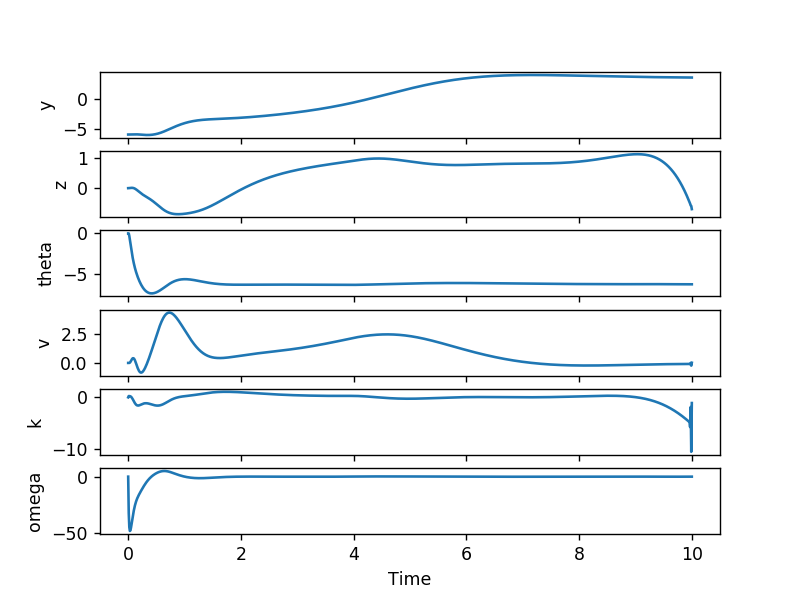

<IPython.core.display.Javascript object>


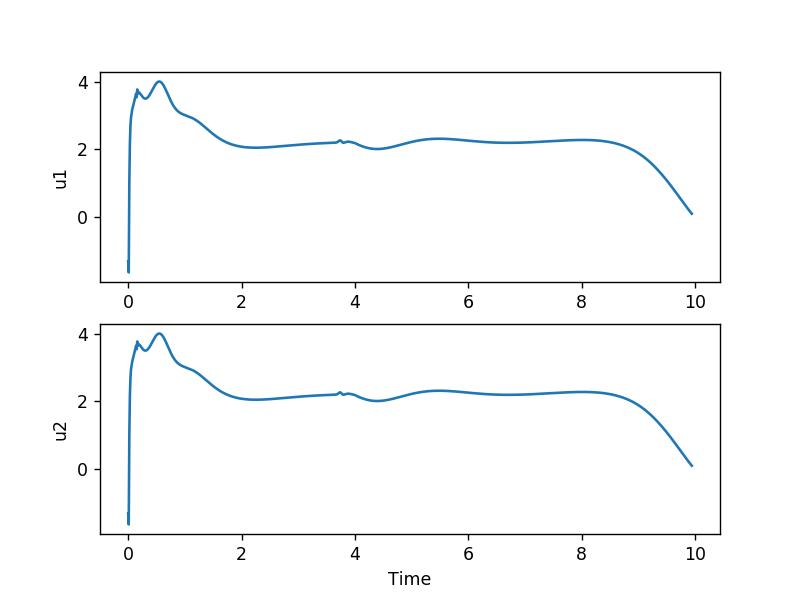

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABEdm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAACBwZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMAOjYb3x/yZTrqOgAAAwAHqAFM
AUoCLkL+EFIPgAn7kmwn4iT8oK6u9Ddz3VZkEL90L8QW50sp2FnXOtiP+8Kw0sy2fXt43m4uAM58
XOiRzE9ZBJhzfX4iWQzFr/B/wcF5Jrbr7+321wZAcGczZ3kNBddfwAfLqxS4uSLsK31QPHIW9Id3
yfvO83yvxLtu9gZMVy8nfFny7pV4sN3Z5r3ib0TXghp9c7yNVvAav2TM9T4gcVj1qAvpGIzoh5oU
19fiSZG1dyglxgh+XF0wJs8G7iDMnT3pOl29O7/y8N//2eZUTtqxnCXok7HS0MjkNgWLs+6WD/xn
R3jKqT3iaOqpvP1cIkG3raSX772q+pacW9QWudirIN3BHcuvez2nv8dARq6SOQ0z5YOVMpOi/ssG
5wUIosWlYH+8nQ1XYRe6FlJwS7zPmm7/Gv/w+coR9FZpCBoT8moiMcIELEY3IRFJW/3o2erYcbcN
mVrvDD3ro4omvmCsgyEpb85t3zneaDEhf883EjhGcGSCzaWrMj4qKgvMHbolViLxPO5ySmkUrmxP
7OAFQ6ubNsurIEn8BOaeHVDISUz/yLcSBYcZ4R3muAAGSDMhj33+UThe8GgtuzWJPho5PBW7+e76
26sSO+euFIpPgE7DnNLD+QG/X6aeDP4yljKdnQwicYOd6dP7m4KFVSyRi84hwKMV+j0aIfQg8Fe8
CLftlJH0exyhDesB1HWpZhKiAH/H1Ow02GdEa44ofLnrSbm80PI9994pLZz1ZSPJ2jj5lKXcWqnZ
ZEN3yk8tXPdf0Gu/Un5YRjgHQaXb/+b0vD+16MNaayCKipeLBVi0rqV6Qp6X89iXWOh2pZOi6V6e
KlqEMlEn/a+QIXyj1DhSnpfQQVehHPAQ2o6POgjkX7R7FI//dlkLje18JIDgXJXjnsrLxoMfDP5n
RsFzCbKkplGNe2iU+U1vtyYAwqaif/H8ZaFxpIehHAeHi649bB+MaUz5o0Es2+nKXLJhmgixJojM
6HzQoqi8dQp0C49H0UAAAC4AxgXUzP4wMRRfS7uiAzoZZXycNteJrFLuzOqgjedDpLobxkGohp0w
zsfhUABHvf8MQjks96eIE5bl2prOThyxauaucaKNfLgJp90rVJCqRdBRqST/TNFwWUnkFym8IRRZ
xxCv41dVpeivC1pflGt0q1W9V1LDAVr+tnu6cm5eMx6eIrr8py84zZ3KxQizPu7WcM2bFk9bXZhD
LLVklbafkzaisdCnkRBkPZpVbyR3GuOhrN4Cw3UHdYQNz5cwZpVFEF1KCnPzFQPQfHJWaicu+3sD
hvNHVPGFn+I2b7ZTNqMnjx05LRIXwrW2aM/ulGXixtaQB/dBAM+L/ugJhDOlFIvvrk5Pp5O5p6BO
5r789lNRKB4R0IujI8936WNb3yipu+te56BVoqc38682b1D1uQqoqKh+/qpAbaNGv7jGkAAEbX+G
0fVTZ58Y29Xy7WhC7SBeIJ/8Wzp9zzG0+04IIwdn3fvmMNDV/2PfCr3Cl5vSM559tKb2nqkalD2/
W6Kxsm5FYPDVSpRq70lkjsn0KbRWoArFhvv2jK1pnP9ak0p9DZn5dDljgZIP2moVud61euISx1JI
aTKL80LplBFFB59bcRArxd01QL8ewfSGE3HY/IQgwXc1dsEXQsnPjpf0Zw1997jVOV9ezCUf/DXK
oAecqnfqXIcn/jKFhgQY8QuFcGy6vGGjVjFP0vW6Y81g98i6/4ukXTwkO1t4oZ3p9hFxGGVqAS1c
iYSo1q9/28A8QxWVRC6sZzzizrY8jTaMV02xq4YjmS3rUv2fV06ZXBAMNlbauB+aJALzNWASYrJM
RZ+XW8USppKEr5wCJetPAAAnjsKQYqL+G8+OTndUDJ6mI5VgtIE72i303t1R4AURQUOiMKahe+G+
bO+whEEgmpxE342+exxhmnp64raP/6AgdUMJQjXdtorGBzoFZG3RgRNG/+odjN9xKvfvshATYF2T
y1wIkC21l+Zf5narT3ekABN22jMhlmCidtjUM5ckdddxVrYgTitYh9xQywOOs+bWzpHw/WyLLbYC
Iu89aFdKe638iMAAKqxMADEIu1qTIe+oid1YPt8/O6eirgBdo9Bf188EkEdFuohstJS9aCOneOPA
NOkpZxWAV+SwEX4AIX3kIZo4OC4e/+dGZuUThuFfNmwK+GxsAiLfZH5GjGKDk8fGi4nIeethWXuw
1NQT+Nhic8ewX8SCvn+0hP2pTrCseoTjgxNP3Hf8YIGatXxHzGWYf6otuZYhxsgxAns0NePcnSO+
mij8GIQD4cYYgDs7oNn2+BnBZluGQCKGNc8Z7C2emMYgxFGjAnkAVeJhzYzMb1/jk+I33a0/0yub
AP/N0c+mwXVKY+kP70y4J884ocYEMCKlYGAt0e+3Q0/9pA287IPOY701cF+Y2Xu/pLN/OVYIv7hZ
IaZITRDMmF41qe8SG8otV+DS743JAREpLKX9uANyKUlISxZbdUhMEIcidZi/RjFt+whOJdK6nFvx
3+ARVMbsqEND9hmVq2aloU3nRQD2EYq5X4IJ5sQ/6Khn5DDUhxpWUmxHnZiDCKtY1EYxhvdGv3pD
EnDk6reqrXqhmKJQulH1Tv4USPVOptbiKhPHxx4J+rMXeQDktY/4GL/3VD1uHKGe+s41XcQTRtYb
pL4SFbCIsMJFlJsd2X/uXHkk7HrB2yomeoT+OpYq0CN6yCNiPXSE18fH7bMQqLzvXv/oblxoYX2g
3NmXSpaS4MWY8mTY1XXaCenNa/f5B8xzubvdbnVVk9kr+6w/iBCuQgF789wJSrZyygTRq5hJ0dMl
G04gNyEun4+Uzocag1WaL

In [30]:
y_goal,z_goal = 4,1
y_start, z_start = -6,0
#hover_t1 = 2
travel_t2 = 10
#hover_t2 = 2


quad = Quadrotor()

#Obstacles
x_obs2=[]
x_obs2.append([0,0,0,0,0,0])
x_obs2.append([0,3,0,0,0,0])
x_obs2.append([0,4,0,0,0,0])
x_obs2.append([0,5,0,0,0,0])
x_obs2.append([0,-1,0,0,0,0])
x_obs2.append([0,-2,0,0,0,0])


horizon_length = 1000
horizon2 = int(round(travel_t2/quad.dt))
y1 = np.zeros(horizon2+1) 
y1.fill(y_goal)
z1 = np.zeros(horizon2+1) 
z1.fill(z_goal)
x_desired = np.array([y1,z1,np.zeros(horizon2+1),np.zeros(horizon2+1),np.zeros(horizon2+1),np.zeros(horizon2+1)])

x_start = np.array([y_start, z_start,0,0,0,0])

A_f = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -quad.g*quad.dt, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
B_f = np.array([[0, 0],[0, 0], [0, 0],[0, 0], [quad.dt/quad.mass, quad.dt/quad.mass], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])


Q = np.diag([20, 20, 0.1, 1, 1, 1])
R = np.diag([10, 10])

P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations_init(A_f,B_f,Q,R,x_desired, horizon2)
x_guess1,u1 = quad.simulate(x_start, finite_horizon_controller_init,  horizon2)

Q = np.diag([20, 20, 0.1, 1, 1, 500])
QN = np.diag([100, 100, 0.1, 1, 1, 500])

R = np.diag([10, 10])

gamma = 0.5
rho = 1
alpha = 1  
for h in range(5):
    P_FH,K_FH,p_FH,k_FH = backward_pass(rho,gamma,x_guess1,u1,Q,R,x_desired, horizon_length,x_obs2)
    x_guess1,u1 = forward_pass(x_start,K_FH,k_FH,x_guess1,u1,x_desired)
    
t = np.linspace(0,quad.dt*(horizon2), horizon2+1)


plt.figure()
plt.subplot(6,1,1)
plt.plot(t,x_guess1[0,:])
plt.ylabel('y')
plt.subplot(6,1,2)
plt.plot(t,x_guess1[1,:])
plt.ylabel('z')
plt.subplot(6,1,3)
plt.plot(t,x_guess1[2,:])
plt.ylabel('theta')
plt.subplot(6,1,4)
plt.plot(t,x_guess1[3,:])
plt.ylabel('v')
plt.subplot(6,1,5)
plt.plot(t,x_guess1[4,:])
plt.ylabel('k')
plt.subplot(6,1,6)
plt.plot(t,x_guess1[5,:])
plt.ylabel('omega')
plt.xlabel('Time')

plt.figure()
plt.title("control u")
plt.subplot(2,1,1)
plt.plot(t[:horizon_length-5],u1[0,:horizon_length-5])
plt.ylabel('u1')
plt.subplot(2,1,2)
plt.plot(t[:horizon_length-5],u1[0,:horizon_length-5])
plt.ylabel('u2')
plt.xlabel('Time')
plt.show()
animate_quad(x_guess1, quad.dt,True,False,True)

In [31]:
#Multiple Obstacles

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


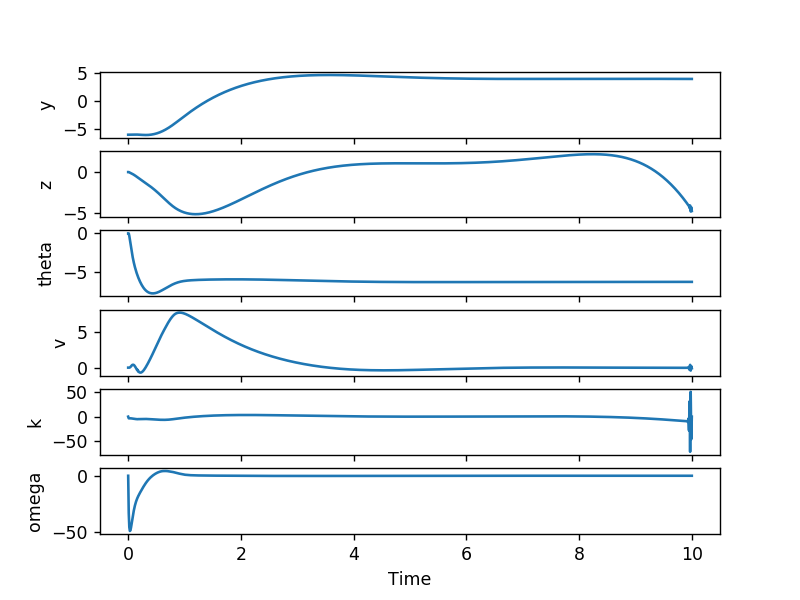

<IPython.core.display.Javascript object>


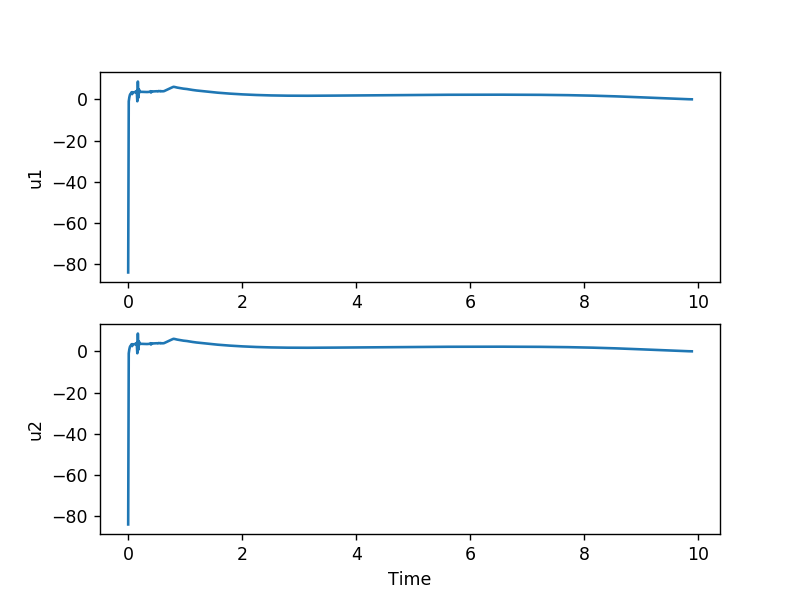

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABLoW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAACQxZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMAOjYb3x/yZTrqOgAAAwAHqAFM
AUoCLkL+EFIPgAn7kmwn4iT8oK6u9Ddz3VZkEL90L8QW50sp2FnXOtiP+8Kw0sy2fXt43m4uAM58
XOiRzE9ZBJhzfX4iWQzFr/B/wcF5Jrbr7+321wZAcGczZ3kNBddfwAfLqxS4uSLsK31QPHIW9Id3
yfvO83yvxLtu9gZMVy8nfFny7pV4sN3Z5r3ib0TXghp9c7yNVvAav2TM9T4gcVj1qAvpGIzoh5oU
19fiSZG1dyglxgh+XF0wJs8G7iDMnT3pOl29O7/y8N//2eZUTtqxnCXok7HS0MjkNgWLs+6WD/xn
R3jKqT3iaOqpvP1cIkG3raSX772q+pacW9QWudirIN3BHcuvez2nv8dARq6SOQ0z5YOVMpOi/ssG
5wUIosWlYH+8nQ1XYRe6FlJwS7zPmm7/Gv/w+coR9FZpCBoT8moiMcIELEY3IRFJW/3o2erYcbcN
mVrvDD3ro4omvmCsgyEpb85t3zneaDEhf883EjhGcGSCzaWrMj4qKgvMHbolViLxPO5ySmkUrmxP
7OAFQ6ubNsurIEn8BOaeHVDISUz/yLcSBYcZ4R3muAAGSDMhj33+UThe8GgtuzWJPho5PBW7+e76
26sSO+euFIpPgE7DnNLD+QG/X6aeDP4yljKdnQwicYOd6dP7m4KFVSyRi84hwKMV+j0aIfQg8Fe8
CLftlJH0exyhDesB1HWpZhKiAH/H1Ow02GdEa44ofLnrSbm80PI9994pLZz1ZSPJ2jj5lKXcWqnZ
ZEN3yk8tXPdf0Gu/Un5YRjgHQaXb/+b0vD+16MNaayCKipeLBVi0rqV6Qp6X89iXWOh2pZOi6V6e
KlqEMlEn/a+QIXyj1DhSnpfQQVehHPAQ2o6POgjkX7R7FI//dlkLje18JIDgXJXjnsrLxoMfDP5n
RsFzCbKkplGNe2iU+U1vtyYAwqaif/H8ZaFxpIehHAeHi649bB+MaUz5o0Es2+nKXLJhmgixJojM
6HzQoqi8dQp0C49H0UAAAC4AxgXUzP4wMRRfS7uiAzoZZXycNteJrFLuzOqgjedDpLobxkGohp0w
zsfhUABHvf8MQjks96eIE5bl2prOThyxauaucaKNfLgJp90rVJCqRdBRqST/TNFwWUnkFym8IRRZ
xxCv41dVpeivC1pflGt0q1W9V1LDAVr+tnu6cm5eMx6eIrr8py84zZ3KxQizPu7WcM2bFk9bXZhD
LLVklbafkzaisdCnkRBkPZpVbyR3GuOhrN4Cw3UHdYQNz5cwZpVFEF1KCnPzFQPQfHJWaicu+3sD
hvNHVPGFn+I2b7ZTNqMnjx05LRIXwrW2aM/ulGXixtaQB/dBAM+L/ugJhDOlFIvvrk5Pp5O5p6BO
5r789lNRKB4R0IujI8936WNb3yipu+te56BVoqc38682b1D1uQqoqKh+/qpAbaNGv7jGkAAEbX+G
0fVTZ58Y29Xy7WhC7SBeIJ/8Wzp9zzG0+04IIwdn3fvmMNDV/2PfCr3Cl5vSM559tKb2nqkalD2/
W6Kxsm5FYPDVSpRq70lkjsn0KbRWoArFhvv2jK1pnP9ak0p9DZn5dDljgZIP2moVud61euISx1JI
aTKL80LplBFFB59bcRArxd01QL8ewfSGE3HY/IQgwXc1dsEXQsnPjpf0Zw1997jVOV9ezCUf/DXK
oAecqnfqXIcn/jKFhgQY8QuFcGy6vGGjVjFP0vW6Y81g98i6/4ukXTwkO1t4oZ3p9hFxGGVqAS1c
iYSo1q9/28A8QxWVRC6sZzzizrY8jTaMV02xq4YjmS3rUv2fV06ZXBAMNlbauB+aJALzNWASYrJM
RZ+XW8USppKEr5wCJetPAAAnjsKQYqL+G8+OTndUDJ6mI5VgtIE72i303t1R4AURQUOiMKahe+G+
bO+whEEgmpxE342+exxhmnp64raP/6AgdUMJQjXdtorGBzoFZG3RgRNG/+odjN9xKvfvshATYF2T
y1wIkC21l+Zf5narT3ekABN22jMhlmCidtjUM5ckdddxVrYgTitYh9xQywOOs+bWzpHw/WyLLbYC
Iu89aFdKe638iMAAKqxMADEIu1qTIe+oid1YPt8/O6eirgBdo9Bf188EkEdFuohstJS9aCOneOPA
NOkpZxWAV+SwEX4AIX3kIZo4OC4e/+dGZuUThuFfNmwK+GxsAiLfZH5GjGKDk8fGi4nIeethWXuw
1NQT+Nhic8ewX8SCvn+0hP2pTrCseoTjgxNP3Hf8YIGatXxHzGWYf6otuZYhxsgxAns0NePcnSO+
mij8GIQD4cYYgDs7oNn2+BnBZluGQCKGNc8Z7C2emMYgxFGjAnkAVeJhzYzMb1/jk+I33a0/0yub
AP/N0c+mwXVKY+kP70y4J884ocYEMCKlYGAt0e+3Q0/9pA287IPOY701cF+Y2Xu/pLN/OVYIv7hZ
IaZITRDMmF41qe8SG8otV+DS743JAREpLKX9uANyKUlISxZbdUhMEIcidZi/RjFt+whOJdK6nFvx
3+ARVMbsqEND9hmVq2aloU3nRQD2EYq5X4IJ5sQ/6Khn5DDUhxpWUmxHnZiDCKtY1EYxhvdGv3pD
EnDk6reqrXqhmKJQulH1Tv4USPVOptbiKhPHxx4J+rMXeQDktY/4GL/3VD1uHKGe+s41XcQTRtYb
pL4SFbCIsMJFlJsd2X/uXHkk7HrB2yomeoT+OpYq0CN6yCNiPXSE18fH7bMQqLzvXv/oblxoYX2g
3NmXSpaS4MWY8mTY1XXaCenNa/f5B8xzubvdbnVVk9kr+6w/iBCuQgF789wJSrZyygTRq5hJ0dMl
G04gNyEun4+Uzocag1WaL

In [32]:
y_goal,z_goal = 4,1
y_start, z_start = -6,0
#hover_t1 = 2
travel_t2 = 10
#hover_t2 = 2


quad = Quadrotor()

x_obs2=[]
x_obs2.append([0,0,0,0,0,0])
x_obs2.append([0,2,0,0,0,0])
x_obs2.append([0,1,0,0,0,0])
x_obs2.append([0,3,0,0,0,0])
x_obs2.append([0,4,0,0,0,0])
x_obs2.append([0,5,0,0,0,0])
x_obs2.append([0,-1,0,0,0,0])
x_obs2.append([0,-2,0,0,0,0])


horizon_length = 1000
horizon2 = int(round(travel_t2/quad.dt))
y1 = np.zeros(horizon2+1) 
y1.fill(y_goal)
z1 = np.zeros(horizon2+1) 
z1.fill(z_goal)
x_desired = np.array([y1,z1,np.zeros(horizon2+1),np.zeros(horizon2+1),np.zeros(horizon2+1),np.zeros(horizon2+1)])

x_start = np.array([y_start, z_start,0,0,0,0])

A_f = np.array([[1, 0, 0, quad.dt, 0, 0],[0, 1, 0, 0, quad.dt, 0],[0, 0, 1, 0, 0, quad.dt],[0, 0, -quad.g*quad.dt, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
B_f = np.array([[0, 0],[0, 0], [0, 0],[0, 0], [quad.dt/quad.mass, quad.dt/quad.mass], [(quad.r/quad.Ixx)*quad.dt, -(quad.r/quad.Ixx)*quad.dt]])


Q = np.diag([20, 20, 0.1, 1, 1, 1])
R = np.diag([10, 10])

P_FH,K_FH,p_FH,k_FH,q_FH = solve_ricatti_equations_init(A_f,B_f,Q,R,x_desired, horizon2)
x_guess1,u1 = quad.simulate(x_start, finite_horizon_controller_init,  horizon2)

Q = np.diag([20, 20, 0.1, 1, 1, 300])
QN = np.diag([100, 100, 0.1, 1, 1, 300])

R = np.diag([100, 100])

gamma = 0.3
rho = 1
alpha = 1  
for h in range(10):
    P_FH,K_FH,p_FH,k_FH = backward_pass(rho,gamma,x_guess1,u1,Q,R,x_desired, horizon_length,x_obs2)
    x_guess1,u1 = forward_pass(x_start,K_FH,k_FH,x_guess1,u1,x_desired)
    
t = np.linspace(0,quad.dt*(horizon2), horizon2+1)



plt.figure()
plt.subplot(6,1,1)
plt.plot(t,x_guess1[0,:])
plt.ylabel('y')
plt.subplot(6,1,2)
plt.plot(t,x_guess1[1,:])
plt.ylabel('z')
plt.subplot(6,1,3)
plt.plot(t,x_guess1[2,:])
plt.ylabel('theta')
plt.subplot(6,1,4)
plt.plot(t,x_guess1[3,:])
plt.ylabel('v')
plt.subplot(6,1,5)
plt.plot(t,x_guess1[4,:])
plt.ylabel('k')
plt.subplot(6,1,6)
plt.plot(t,x_guess1[5,:])
plt.ylabel('omega')
plt.xlabel('Time')

plt.figure()
plt.title("control u")
plt.subplot(2,1,1)
plt.plot(t[:horizon_length-10],u1[0,:horizon_length-10])
plt.ylabel('u1')
plt.subplot(2,1,2)
plt.plot(t[:horizon_length-10],u1[0,:horizon_length-10])
plt.ylabel('u2')
plt.xlabel('Time')
plt.show()
animate_quad(x_guess1, quad.dt,False,False,False,True)